In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

zsh:1: command not found: nvidia-smi


In [2]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '1'
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from enum import Enum
import imageio
import hashlib
import copy
import time
import abc
import random
import collections
import itertools

%matplotlib inline
plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format='retina'

dtype = 'float32'
tf.keras.backend.set_floatx(dtype)

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2022-04-10 15:02:27.598090: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-10 15:02:27.598118: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-10 15:02:29.861753: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-10 15:02:29.861789: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-10 15:02:29.861819: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (batbook): /proc/driver/nvidia/version does not exist


In [3]:
################################################################################
# DATASETS
################################################################################


def get_dataset_sample(X, y, fraction, seed=None):
    if seed is not None:
        np.random.seed(seed)  # Set random seed
    selection = np.random.choice([True, False], len(X), p=[fraction, 1 - fraction])
    if seed is not None:
        np.random.seed()  # Unset random seed
    X_sampled = X[selection]
    y_sampled = y[selection]
    return X_sampled, y_sampled


class Dataset:
    def __init__(self, X_train, y_train, X_test, y_test, shape, shape_flattened, fraction, vision=True, standardize=True):
        if fraction is not None:
            X_train, y_train = get_dataset_sample(X_train, y_train, fraction, seed=42)
            X_test, y_test = get_dataset_sample(X_test, y_test, fraction, seed=42)
        
        X_train = X_train.astype(dtype)
        y_train = y_train.astype(dtype)
        X_test = X_test.astype(dtype)
        y_test = y_test.astype(dtype)

        if vision:
            X_train = X_train / 255.0
            X_test = X_test / 255.0

        X_train = np.reshape(X_train, shape_flattened)
        X_test = np.reshape(X_test, shape_flattened)

        X = np.concatenate((X_train, X_test), axis=0)
        y = np.concatenate((y_train, y_test), axis=0)

        if standardize:
            from sklearn.preprocessing import StandardScaler

            scaler = StandardScaler()
            scaler.fit(X_train)  # Scaling each feature independently

            X_norm = scaler.transform(X)
            X_train_norm = scaler.transform(X_train)
            X_test_norm = scaler.transform(X_test)
        else:
            X_norm = X.copy()
            X_train_norm = X_train.copy()
            X_test_norm = X_test.copy()

        X_norm = np.reshape(X_norm, shape)
        X_train_norm = np.reshape(X_train_norm, shape)
        X_test_norm = np.reshape(X_test_norm, shape)

        del X, X_train, X_test

        self.X_norm = X_norm
        self.y = y
        self.X_train_norm = X_train_norm
        self.y_train = y_train
        self.X_test_norm = X_test_norm
        self.y_test = y_test


def get_cifar_10_dataset(fraction=None):
    cifar10 = tf.keras.datasets.cifar10
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    shape = (-1, 32, 32, 3)
    shape_flattened = (-1, 3072)  # Scaling each feature independently
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened, fraction=fraction)


def get_cifar_100_dataset(fraction=None):
    cifar100 = tf.keras.datasets.cifar100
    (X_train, y_train), (X_test, y_test) = cifar100.load_data()
    shape = (-1, 32, 32, 3)
    shape_flattened = (-1, 3072)  # Scaling each feature independently
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened, fraction=fraction)


def get_svhn_dataset(fraction=None):
    from urllib.request import urlretrieve
    from scipy import io

    train_filename, _ = urlretrieve('http://ufldl.stanford.edu/housenumbers/train_32x32.mat')
    test_filename, _ = urlretrieve('http://ufldl.stanford.edu/housenumbers/test_32x32.mat')

    X_train = io.loadmat(train_filename, variable_names='X').get('X')
    y_train = io.loadmat(train_filename, variable_names='y').get('y')
    X_test = io.loadmat(test_filename, variable_names='X').get('X')
    y_test = io.loadmat(test_filename, variable_names='y').get('y')

    X_train = np.moveaxis(X_train, -1, 0)
    y_train -= 1
    X_test = np.moveaxis(X_test, -1, 0)
    y_test -= 1

    shape = (-1, 32, 32, 3)
    shape_flattened = (-1, 3072)  # Scaling each feature independently
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened, fraction=fraction)


def get_tiny_imagenet_dataset(fraction=None):
    """
    Original source: https://github.com/sonugiri1043/Train_ResNet_On_Tiny_ImageNet/blob/master/Train_ResNet_On_Tiny_ImageNet.ipynb
    Original author: sonugiri1043@gmail.com
    """

    if not os.path.isdir('IMagenet'):
        ! git clone https://github.com/seshuad/IMagenet

    print("Processing the downloaded dataset...")

    path = 'IMagenet/tiny-imagenet-200/'

    id_dict = {}
    for i, line in enumerate(open(path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i

    train_data = list()
    test_data = list()
    train_labels = list()
    test_labels = list()

    for key, value in id_dict.items():
        train_data += [imageio.imread(path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)), pilmode='RGB') for i in range(500)]
        train_labels_ = np.array([[0]*200]*500)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

    for line in open(path + 'val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(imageio.imread(path + 'val/images/{}'.format(img_name), pilmode='RGB'))
        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    X_train = np.array(train_data)
    y_train = np.argmax(np.array(train_labels), axis=1)
    X_test = np.array(test_data)
    y_test = np.argmax(np.array(test_labels), axis=1)

    shape = (-1, 64, 64, 3)
    shape_flattened = (-1, 12288)  # Scaling each feature independently
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened, fraction=fraction)


def get_mnist_dataset(fraction=None):
    mnist = tf.keras.datasets.mnist
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    shape = (-1, 28, 28, 1)
    shape_flattened = (-1, 1)  # Scaling all features together
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened, fraction=fraction)


def get_fashion_mnist_dataset(fraction=None):
    fashion_mnist = tf.keras.datasets.fashion_mnist
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    shape = (-1, 28, 28, 1)
    shape_flattened = (-1, 1)  # Scaling all features together
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened, fraction=fraction)


def get_fifteen_puzzle_dataset(path=None, fraction=None):
    from sklearn.model_selection import train_test_split

    if path is None:
        from google.colab import drive
        drive.mount('/content/gdrive')
        path = 'gdrive/MyDrive/15-costs-v3.csv'
    costs = pd.read_csv(path)

    X_raw = costs.iloc[:,:-1].values
    y = costs['cost'].values
    X = np.apply_along_axis(lambda x: np.eye(16)[x].ravel(), 1, X_raw)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, X_raw, y

    shape = (-1, 256)
    shape_flattened = (-1, 256)  # Scaling all features together
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened, vision=False, fraction=fraction)


################################################################################
# REGULARIZERS
################################################################################


class Regularizer(tf.keras.regularizers.Regularizer):
    def __init__(self):
        self.n_new_neurons = 0
        self.scaling_tensor = None
        self.set_regularization_penalty(0.)
        self.set_regularization_method(None)
    
    def copy(self):
        regularizer_copy = Regularizer.__new__(Regularizer)
        regularizer_copy.n_new_neurons = self.n_new_neurons
        regularizer_copy.scaling_tensor = self.scaling_tensor
        regularizer_copy.set_regularization_penalty(self.regularization_penalty)
        regularizer_copy.set_regularization_method(self.regularization_method)
        return regularizer_copy

    def __call__(self, x):
        if self.regularization_method is None or self.regularization_penalty == 0:
            return 0
        elif self.regularization_method == 'weighted_l1':
            return self.weighted_l1(x)
        elif self.regularization_method == 'weighted_l1_reordered':
            return self.weighted_l1_reordered(x)
        elif self.regularization_method == 'group_sparsity':
            return self.group_sparsity(x)
        elif self.regularization_method == 'l1':
            return self.l1(x)
        else:
            raise NotImplementedError(f"Unknown regularization method {self.regularization_method}")
    
    def weighted_l1(self, x):
        # I.e. for a parameter matrix of 4 input and 10 output neurons:
        #
        # [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]
        #
        # the scaling tensor, as well as the resulting weighted values, could be:
        #
        # [[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]]
        #
        # Therefore every additional output neuron is regularized more.

        scaling_tensor = tf.cumsum(tf.constant(self.regularization_penalty, shape=x.shape, dtype=dtype), axis=-1)
        weighted_values = scaling_tensor * tf.abs(x)
        return tf.reduce_sum(weighted_values)
    
    def weighted_l1_reordered(self, x):
        # I.e. for a parameter matrix of 4 input and 10 output neurons:
        #
        # [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]
        #
        # the scaling tensor, as well as the resulting weighted values, could be:
        #
        # [[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]]
        #
        # Therefore every additional output neuron is regularized more.

        if self.update_scaling_tensor:
            scaling_tensor_raw = tf.cumsum(tf.constant(self.regularization_penalty, shape=x.shape, dtype=dtype), axis=-1)

            scaling_tensor_old_neurons = scaling_tensor_raw[:, :-self.n_new_neurons]
            scaling_tensor_new_neurons = scaling_tensor_raw[:, -self.n_new_neurons:]
            scaling_tensor_old_neurons_shuffled = tf.transpose(tf.random.shuffle(tf.transpose(scaling_tensor_old_neurons)))
            self.scaling_tensor = tf.concat([scaling_tensor_old_neurons_shuffled, scaling_tensor_new_neurons], axis=-1)
            self.update_scaling_tensor = False

        weighted_values = self.scaling_tensor * tf.abs(x)
        return tf.reduce_sum(weighted_values)
    
    def group_sparsity(self, x):
        # I.e. for a parameter matrix of 3 input and 5 output neurons:
        #
        # [[1., 1., 1., 1., 1.],
        #  [1., 2., 2., 1., 2.],
        #  [2., 2., 3., 1., 3.]]
        #
        # The resulting vector of group norms is [2., 2., 3., 1., 3.], therefore for
        # every output neuron, its incoming connections form a group.

        group_norms = tf.norm(x, ord=2, axis=0)
        # assert group_norms.shape[0] == x.shape[1]
        return self.regularization_penalty * tf.reduce_sum(group_norms)
    
    def l1(self, x):
        weighted_values = self.regularization_penalty * tf.abs(x)
        return tf.reduce_sum(weighted_values)
    
    def prune(self):
        self.n_new_neurons = 0
        if self.regularization_method == 'weighted_l1_reordered':
            self.update_scaling_tensor = True
    
    def grow(self, n_new_neurons):
        self.n_new_neurons = n_new_neurons
        if self.regularization_method == 'weighted_l1_reordered':
            self.update_scaling_tensor = True
    
    def set_regularization_penalty(self, regularization_penalty):
        self.regularization_penalty = regularization_penalty
    
    def set_regularization_method(self, regularization_method):
        self.regularization_method = regularization_method
        if self.regularization_method == 'weighted_l1_reordered':
            self.update_scaling_tensor = True
        else:
            self.update_scaling_tensor = None

    def get_config(self):
        return {'regularization_penalty': float(self.regularization_penalty)}


################################################################################
# LAYERS
################################################################################


class DASLayer(tf.keras.layers.Layer):
    def __init__(self, input_shape):
        super().__init__()

        self._input_shape = input_shape
        self._built = False


class Dense(DASLayer):
    def __init__(self, units, activation, kernel_initializer='glorot_uniform', 
                 bias_initializer='zeros', input_shape=None, fixed_size=False,
                 regularizer=None):
        super().__init__(input_shape)

        self.units = units
        self.activation = activation
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.fixed_size = fixed_size
        
        self.A = tf.keras.activations.get(activation)
        self.W_init = tf.keras.initializers.get(kernel_initializer)
        self.b_init = tf.keras.initializers.get(bias_initializer)
        if regularizer is not None:
            self.regularizer = regularizer
        else:
            self.regularizer = Regularizer()
    
    def copy(self):
        layer_copy = Dense.__new__(Dense)
        super(Dense, layer_copy).__init__(self._input_shape)
        
        layer_copy.units = self.units
        layer_copy.activation = self.activation
        layer_copy.kernel_initializer = self.kernel_initializer
        layer_copy.bias_initializer = self.bias_initializer
        layer_copy.fixed_size = self.fixed_size
        
        layer_copy.A = self.A
        layer_copy.W_init = self.W_init
        layer_copy.b_init = self.b_init
        layer_copy.regularizer = self.regularizer.copy()
        
        layer_copy.W = tf.Variable(
            name='W',
            initial_value=self.W,
            trainable=True)
        
        layer_copy.b = tf.Variable(
            name='b',
            initial_value=self.b,
            trainable=True)
        
        layer_copy.add_regularizer_loss()
        
        layer_copy._built = True
        return layer_copy
    
    def build(self, input_shape):
        if self._built:
            return
            
        input_units = input_shape[-1]

        self.W = tf.Variable(
            name='W',
            initial_value=self.W_init(shape=(input_units, self.units), dtype=dtype),
            trainable=True)
        
        self.b = tf.Variable(
            name='b',
            initial_value=self.b_init(shape=(self.units,), dtype=dtype),
            trainable=True)
        
        self.add_regularizer_loss()
        
        self._built = True
    
    def call(self, inputs, training=None):
        return self.A(tf.matmul(inputs, self.W) + self.b)
    
    def add_regularizer_loss(self):
        self.add_loss(lambda: self.regularizer(tf.concat([self.W, tf.reshape(self.b, (1, -1))], axis=0)))

    def get_size(self):
        return self.W.shape[0], self.W.shape[1]
    
    def prune(self, threshold, active_input_units_indices):
        # Remove connections from pruned units in previous layer
        new_W = tf.gather(self.W.value(), active_input_units_indices, axis=0)

        if self.fixed_size:
            active_output_neurons_indices = list(range(new_W.shape[1]))
        else:
            # Prune units in this layer
            weights_with_biases = tf.concat([new_W, tf.reshape(self.b.value(), (1, -1))], axis=0)
            neurons_are_active = tf.math.reduce_max(tf.abs(weights_with_biases), axis=0) >= threshold
            active_output_neurons_indices = tf.reshape(tf.where(neurons_are_active), (-1,))
            
            new_W = tf.gather(new_W, active_output_neurons_indices, axis=1)
            new_b = tf.gather(self.b.value(), active_output_neurons_indices, axis=0)

            self.b = tf.Variable(name='b', initial_value=new_b, trainable=True)

        self.W = tf.Variable(name='W', initial_value=new_W, trainable=True)

        self.regularizer.prune()
        return active_output_neurons_indices
    
    def grow(self, n_new_input_units, percentage, min_new_units, scaling_factor):
        if n_new_input_units > 0:
            # Add connections to grown units in previous layer
            W_growth = self.W_init(shape=(self.W.shape[0] + n_new_input_units, self.W.shape[1]), dtype=dtype)[-n_new_input_units:, :] * scaling_factor  # TODO is it better to be multiplying here by scaling_factor? It does help with not increasing the max weights of existing neurons when new neurons are added.
            new_W = tf.concat([self.W.value(), W_growth], axis=0)
        else:
            new_W = self.W.value()

        if self.fixed_size:
            n_new_output_units = 0
        else:
            # Grow new units in this layer
            n_new_output_units = max(min_new_units, int(new_W.shape[1] * percentage))
            if n_new_output_units > 0:
                W_growth = self.W_init(shape=(new_W.shape[0], new_W.shape[1] + n_new_output_units), dtype=dtype)[:, -n_new_output_units:] * scaling_factor
                b_growth = self.b_init(shape=(n_new_output_units,), dtype=dtype)  # TODO for all possible bias initializers to work properly, the whole bias vector should be initialized at once
                new_W = tf.concat([new_W, W_growth], axis=1)
                new_b = tf.concat([self.b.value(), b_growth], axis=0)

                self.b = tf.Variable(name='b', initial_value=new_b, trainable=True)

        self.W = tf.Variable(name='W', initial_value=new_W, trainable=True)

        self.regularizer.grow(n_new_output_units)
        return n_new_output_units
    
    def mutate(self, mutation_strength):
        self.W.assign_add(tf.random.normal(self.W.shape, mean=0.0, stddev=mutation_strength))
        self.b.assign_add(tf.random.normal(self.b.shape, mean=0.0, stddev=mutation_strength))
    
    def set_regularization_penalty(self, regularization_penalty):
        if not self.fixed_size:
            self.regularizer.set_regularization_penalty(regularization_penalty)
    
    def set_regularization_method(self, regularization_method):
        if not self.fixed_size:
            self.regularizer.set_regularization_method(regularization_method)
    
    def get_param_string():
        param_string = ""
        weights_with_bias = tf.concat([self.W, tf.reshape(self.b, (1, -1))], axis=0)
        max_parameters = tf.math.reduce_max(tf.abs(weights_with_bias), axis=0).numpy()
        magnitudes = np.floor(np.log10(max_parameters))
        for m in magnitudes:
            if m > 0:
                m = 0
            param_string += str(int(-m))
        return param_string


class Conv2D(DASLayer):
    def __init__(self, filters, filter_size, activation, strides=(1, 1), 
                 padding='SAME', kernel_initializer='glorot_uniform',
                 bias_initializer='zeros', input_shape=None, fixed_size=False,
                 regularizer=None):
        super().__init__(input_shape)
    
        self.filters = filters
        self.filter_size = filter_size
        self.activation = activation
        self.strides = strides
        self.padding = padding
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.fixed_size = fixed_size
        
        self.A = tf.keras.activations.get(activation)
        self.F_init = tf.keras.initializers.get(kernel_initializer)
        self.b_init = tf.keras.initializers.get(bias_initializer)
        if regularizer is not None:
            self.regularizer = regularizer
        else:
            self.regularizer = Regularizer()
    
    def copy(self):
        layer_copy = Conv2D.__new__(Conv2D)
        super(Conv2D, layer_copy).__init__(self._input_shape)
        
        layer_copy.filters = self.filters
        layer_copy.filter_size = self.filter_size
        layer_copy.activation = self.activation
        layer_copy.strides = self.strides
        layer_copy.padding = self.padding
        layer_copy.kernel_initializer = self.kernel_initializer
        layer_copy.bias_initializer = self.bias_initializer
        layer_copy.fixed_size = self.fixed_size
        
        layer_copy.A = self.A
        layer_copy.F_init = self.F_init
        layer_copy.b_init = self.b_init
        layer_copy.regularizer = self.regularizer.copy()
        
        layer_copy.F = tf.Variable(
            name='F',
            initial_value=self.F,
            trainable=True)
        
        layer_copy.b = tf.Variable(
            name='b',
            initial_value=self.b,
            trainable=True)
        
        layer_copy.add_regularizer_loss()
        
        layer_copy._built = True
        return layer_copy
    
    def build(self, input_shape):
        if self._built:
            return

        input_filters = input_shape[-1]

        self.F = tf.Variable(
            name='F',
            initial_value=self.F_init(
                shape=(self.filter_size[0], self.filter_size[1], input_filters, self.filters), dtype=dtype
            ),
            trainable=True)
        
        self.b = tf.Variable(
            name='b',
            initial_value=self.b_init(shape=(self.filters,), dtype=dtype),
            trainable=True)

        self.add_regularizer_loss()
        
        self._built = True
    
    def call(self, inputs, training=None):
        y = tf.nn.conv2d(inputs, self.F, strides=self.strides, padding=self.padding)
        y = tf.nn.bias_add(y, self.b)
        y = self.A(y)
        return y
    
    def add_regularizer_loss(self):
        self.add_loss(lambda: self.regularizer(tf.concat([tf.reshape(self.F, (-1, self.F.shape[-1])), tf.reshape(self.b, (1, -1))], axis=0)))
    
    def get_size(self):
        return self.F.shape[-2], self.F.shape[-1]
    
    def prune(self, threshold, active_input_units_indices):
        # Remove connections from pruned units in previous layer
        new_F = tf.gather(self.F.value(), active_input_units_indices, axis=-2)

        if self.fixed_size:
            active_output_filters_indices = list(range(new_F.shape[-1]))
        else:
            # Prune units in this layer
            F_reduced_max = tf.reshape(tf.math.reduce_max(tf.abs(new_F), axis=(0, 1, 2)), (1, -1))
            F_reduced_max_with_biases = tf.concat([F_reduced_max, tf.reshape(self.b.value(), (1, -1))], axis=0)
            filters_are_active = tf.math.reduce_max(tf.abs(F_reduced_max_with_biases), axis=0) >= threshold
            active_output_filters_indices = tf.reshape(tf.where(filters_are_active), (-1,))
            
            new_F = tf.gather(new_F, active_output_filters_indices, axis=-1)
            new_b = tf.gather(self.b.value(), active_output_filters_indices, axis=0)

            self.b = tf.Variable(name='b', initial_value=new_b, trainable=True)

        self.F = tf.Variable(name='F', initial_value=new_F, trainable=True)

        self.regularizer.prune()
        return active_output_filters_indices

    def grow(self, n_new_input_units, percentage, min_new_units, scaling_factor):
        if n_new_input_units > 0:
            # Add connections to grown units in previous layer
            F_growth = self.F_init(shape=(self.F.shape[0], self.F.shape[1], self.F.shape[2] + n_new_input_units, self.F.shape[3]), dtype=dtype)[:, :, -n_new_input_units:, :] * scaling_factor  # TODO is it better to be multiplying here by scaling_factor? It does help with not increasing the max weights of existing neurons when new neurons are added.
            new_F = tf.concat([self.F.value(), F_growth], axis=-2)
        else:
            new_F = self.F.value()

        if self.fixed_size:
            n_new_output_units = 0
        else:
            # Grow new units in this layer
            n_new_output_units = max(min_new_units, int(new_F.shape[-1] * percentage))
            if n_new_output_units > 0:
                F_growth = self.F_init(shape=(new_F.shape[0], new_F.shape[1], new_F.shape[2], new_F.shape[3] + n_new_output_units), dtype=dtype)[:, :, :, -n_new_output_units:] * scaling_factor
                b_growth = self.b_init(shape=(n_new_output_units,), dtype=dtype)  # TODO for all possible bias initializers to work properly, the whole bias vector should be initialized at once
                new_F = tf.concat([new_F, F_growth], axis=-1)
                new_b = tf.concat([self.b.value(), b_growth], axis=0)

                self.b = tf.Variable(name='b', initial_value=new_b, trainable=True)

        self.F = tf.Variable(name='F', initial_value=new_F, trainable=True)

        self.regularizer.grow(n_new_output_units)
        return n_new_output_units
    
    def mutate(self, mutation_strength):
        self.F.assign_add(tf.random.normal(self.F.shape, mean=0.0, stddev=mutation_strength))
        self.b.assign_add(tf.random.normal(self.b.shape, mean=0.0, stddev=mutation_strength))
    
    def set_regularization_penalty(self, regularization_penalty):
        if not self.fixed_size:
            self.regularizer.set_regularization_penalty(regularization_penalty)
    
    def set_regularization_method(self, regularization_method):
        if not self.fixed_size:
            self.regularizer.set_regularization_method(regularization_method)

    def get_param_string():
        param_string = ""
        # TODO
        return param_string


class Flatten(tf.keras.layers.Layer):
    def call(self, inputs, training=None):
        return tf.reshape(tf.transpose(inputs, perm=[0, 3, 1, 2]), (inputs.shape[0], -1))
    
    # def copy(self):
    #     return Flatten()


################################################################################
# MODELS
################################################################################


class Epoch:
    def __init__(self, grow, prune, regularization_penalty, regularization_method):
        self.grow = grow
        self.prune = prune
        self.regularization_penalty = regularization_penalty
        self.regularization_method = regularization_method
    
    def __str__(self):
        return f'{int(self.grow)}{int(self.prune)}{self.regularization_penalty}{self.regularization_method}'
    
    def __repr__(self):
        return self.__str__()


class DynamicEpoch(Epoch):
    def __init__(self, regularization_penalty, regularization_method):
        super().__init__(True, True, regularization_penalty, regularization_method)


class StaticEpoch(Epoch):
    def __init__(self, regularization_penalty, regularization_method):
        super().__init__(False, False, regularization_penalty, regularization_method)


class StaticEpochNoRegularization(StaticEpoch):
    def __init__(self):
        super().__init__(0., None)


class Schedule:
    def __init__(self, epochs):
        self.epochs = epochs

    def __iter__(self):
        return self.epochs.__iter__()
    
    def __len__(self):
        return len(self.epochs)
    
    def __str__(self):
        text = ''.join([str(epoch) for epoch in self.epochs])
        _hash = hashlib.sha1(text.encode('utf-8')).hexdigest()[:10]
        return f'{_hash}({self.epochs[0].regularization_penalty})'
    
    def __repr__(self):
        return self.__str__()


class Sequential(tf.keras.Model):
    def __init__(self, layers):
        super().__init__()
        
        self.lrs = layers
        
    def call(self, inputs, training=None):
        x = inputs
        for layer in self.lrs:
            x = layer(x, training=training)
        return x
    
    def copy(self):
        copied_layers = list()
        for layer in self.lrs:
            if isinstance(layer, DASLayer):
                layer_copy = layer.copy()
#                 layer_copy = copy.deepcopy(layer)
#                 layer_copy.add_regularizer_loss()
            else:
                layer_copy = copy.deepcopy(layer)
            copied_layers.append(layer_copy)
        
        model_copy = Sequential(copied_layers)
        return model_copy
    
    def get_layer_input_shape(self, target_layer):
        if target_layer._input_shape is not None:
            return target_layer._input_shape

        input = np.random.normal(size=(1,) + self.lrs[0]._input_shape)
        for layer in self.lrs:
            if layer is target_layer:
                return tuple(input.shape[1:])
            input = layer(input)
        raise Exception("Layer not found in the model.")

    def get_layer_output_shape(self, target_layer):
        input = np.random.normal(size=(1,) + self.lrs[0]._input_shape)
        for layer in self.lrs:
            output = layer(input)
            if layer is target_layer:
                return tuple(output.shape[1:])
            input = output
        raise Exception("Layer not found in the model.")
    
    def get_layer_sizes(self):
        """
        Returns the sizes of all layers in the model, including the input and output layer.
        """
        layer_sizes = list()
        first_layer = True
        for l in range(len(self.lrs)):
            layer = self.lrs[l]
            if isinstance(layer, DASLayer):
                layer_size = layer.get_size()
                if first_layer:
                    layer_sizes.append(layer_size[0])
                    first_layer = False
                layer_sizes.append(layer_size[1])
        return layer_sizes
    
    def get_hidden_layer_sizes(self):
        return self.get_layer_sizes()[1:-1]
    
    def get_regularization_penalty(self):
        #TODO improve
        return self.lrs[-2].regularizer.regularization_penalty
    
    def set_regularization_penalty(self, regularization_penalty):
        for layer in self.lrs:
            if isinstance(layer, DASLayer) and not layer.fixed_size:
                layer.set_regularization_penalty(regularization_penalty)
    
    def set_regularization_method(self, regularization_method):
        for layer in self.lrs:
            if isinstance(layer, DASLayer) and not layer.fixed_size:
                layer.set_regularization_method(regularization_method)

    def prune(self, params):
        input_shape = self.get_layer_input_shape(self.lrs[0])
        n_input_units = input_shape[-1]
        active_units_indices = list(range(n_input_units))

        last_custom_layer = None
        for layer in self.lrs:
            if isinstance(layer, DASLayer):
                if last_custom_layer is not None and type(last_custom_layer) != type(layer):
                    if type(last_custom_layer) == Conv2D and type(layer) == Dense:
                        convolutional_shape = self.get_layer_output_shape(last_custom_layer)
                        active_units_indices = self.convert_channel_indices_to_flattened_indices(active_units_indices, convolutional_shape)
                    else:
                        raise Exception("Incorrect order of custom layer types.")
                active_units_indices = layer.prune(params.pruning_threshold, active_units_indices)
                last_custom_layer = layer
    
    def grow(self, params):   
        n_new_units = 0

        last_custom_layer = None
        for layer in self.lrs:
            if isinstance(layer, DASLayer):
                if last_custom_layer is not None and type(last_custom_layer) != type(layer):
                    if type(last_custom_layer) == Conv2D and type(layer) == Dense:
                        convolutional_shape = self.get_layer_output_shape(last_custom_layer)
                        n_new_units = n_new_units * convolutional_shape[0] * convolutional_shape[1]
                    else:
                        raise Exception("Incorrect order of custom layer types.")
                n_new_units = layer.grow(n_new_units, params.growth_percentage, min_new_units=params.min_new_neurons, scaling_factor=params.pruning_threshold)
                last_custom_layer = layer
    
    def mutate(self, mutation_strength):
        for layer in self.lrs:
            if isinstance(layer, DASLayer):
                layer.mutate(mutation_strength)
    
    @staticmethod
    def convert_channel_indices_to_flattened_indices(channel_indices, convolutional_shape):
        dense_indices = list()
        units_per_channel = convolutional_shape[0] * convolutional_shape[1]
        for channel_index in channel_indices:
            for iter in range(units_per_channel):
                dense_indices.append(channel_index * units_per_channel + iter)
        return dense_indices
    
    def print_neurons(self):
        for layer in self.lrs[:-1]:
            print(layer.get_param_string())
    
    def evaluate(self, params, summed_training_loss, summed_training_metric):
        # Calculate training loss and metric
        if summed_training_loss is not None:
            loss = summed_training_loss / params.x.shape[0]
        else:
            loss = None
        
        if summed_training_metric is not None:
            metric = summed_training_metric / params.x.shape[0]
        else:
            metric = None
        
        # Calculate val loss and metric
        summed_val_loss = 0
        summed_val_metric = 0
        n_val_instances = 0
        
        for step, (x_batch, y_batch) in enumerate(params.val_dataset):
            # y_pred = tf.reshape(self(x_batch, training=False), y_batch.shape)
            y_pred = self(x_batch, training=False)
            summed_val_loss += tf.reduce_sum(params.loss_fn(y_batch, y_pred))
            summed_val_metric += float(tf.reduce_sum(params.metric_fn(y_batch, y_pred)))
            n_val_instances += x_batch.shape[0]
        
        val_loss = summed_val_loss / n_val_instances
        val_metric = summed_val_metric / n_val_instances

        return loss, metric, val_loss, val_metric

    def list_params(self):
        trainable_count = np.sum([K.count_params(w) for w in self.trainable_weights])
        non_trainable_count = np.sum([K.count_params(w) for w in self.non_trainable_weights])
        total_count = trainable_count + non_trainable_count

        print('Total params: {:,}'.format(total_count))
        print('Trainable params: {:,}'.format(trainable_count))
        print('Non-trainable params: {:,}'.format(non_trainable_count))

        return total_count, trainable_count, non_trainable_count
    
    def print_epoch_statistics(self, params, summed_training_loss, summed_training_metric, message=None, require_result=False):
        if not params.verbose:
            if require_result:
                return self.evaluate(params, summed_training_loss, summed_training_metric)
            else:
                return
        
        loss, metric, val_loss, val_metric = self.evaluate(params, summed_training_loss, summed_training_metric)  

        if message is not None:
            print(message)
        
        print(f"loss: {loss} - metric: {metric} - val_loss: {val_loss} - val_metric: {val_metric} - penalty: {self.get_regularization_penalty()}")
        hidden_layer_sizes = self.get_hidden_layer_sizes()
        print(f"hidden layer sizes: {hidden_layer_sizes}, total units: {sum(hidden_layer_sizes)}")
        if params.print_neurons:
            self.print_neurons()
        
        if require_result:
            return loss, metric, val_loss, val_metric
    
    def update_history(self, params, loss, metric, val_loss, val_metric):
        params.history['loss'].append(float(loss))
        params.history['metric'].append(float(metric))
        params.history['val_loss'].append(float(val_loss))
        params.history['val_metric'].append(float(val_metric))
        params.history['hidden_layer_sizes'].append(self.get_hidden_layer_sizes())
    
    @staticmethod
    def prepare_datasets(x, y, batch_size, validation_data):
        train_dataset = tf.data.Dataset.from_tensor_slices((x, y))
        train_dataset = train_dataset.shuffle(buffer_size=20000).batch(batch_size)
        val_dataset = tf.data.Dataset.from_tensor_slices(validation_data).batch(batch_size)
        return train_dataset.prefetch(tf.data.AUTOTUNE), val_dataset.prefetch(tf.data.AUTOTUNE)
    
    def manage_dynamic_regularization(self, params, val_loss):
        if val_loss >= params.best_conditional_val_loss * params.stall_coefficient:
            # Training is currently in stall
            if not params.training_stalled:
                penalty = self.get_regularization_penalty() * params.regularization_penalty_multiplier
                print("Changing penalty...")
                # TODO this must be modified, penalty can differ for each layer
                self.set_regularization_penalty(penalty)
                params.training_stalled = True
        else:
            params.best_conditional_val_loss = val_loss
            params.training_stalled = False
    
    def grow_wrapper(self, params):
        dynamic_reqularization_active = params.regularization_penalty_multiplier != 1.
        if dynamic_reqularization_active:
            loss, metric, val_loss, val_metric = self.print_epoch_statistics(params, None, None, "Before growing:", require_result=True)
            self.manage_dynamic_regularization(params, val_loss)
        else:
            self.print_epoch_statistics(params, None, None, "Before growing:")

        self.grow(params)
        self.print_epoch_statistics(params, None, None, "After growing:")
    
    def prune_wrapper(self, params, summed_loss, summed_metric):
        loss, metric, _, _ = self.print_epoch_statistics(params, summed_loss, summed_metric, "Before pruning:", require_result=True)
        self.prune(params)
        _, _, val_loss, val_metric = self.print_epoch_statistics(params, None, None, "After pruning:", require_result=True)
        self.update_history(params, loss, metric, val_loss, val_metric)
    
    class ParameterContainer:
        def __init__(self, x, y, optimizer, batch_size, min_new_neurons, validation_data, pruning_threshold, regularization_penalty_multiplier, 
                     stall_coefficient, growth_percentage, mini_epochs_per_epoch, verbose, print_neurons, use_static_graph, loss_fn, metric_fn):
            self.x = x
            self.y = y
            self.optimizer = optimizer
            self.batch_size = batch_size
            self.min_new_neurons = min_new_neurons
            self.validation_data = validation_data
            self.pruning_threshold = pruning_threshold
            self.regularization_penalty_multiplier = regularization_penalty_multiplier
            self.stall_coefficient = stall_coefficient
            self.growth_percentage = growth_percentage
            self.mini_epochs_per_epoch = mini_epochs_per_epoch
            self.verbose = verbose
            self.print_neurons = print_neurons
            self.use_static_graph = use_static_graph
            self.loss_fn = loss_fn
            self.metric_fn = metric_fn

            self.train_dataset, self.val_dataset = Sequential.prepare_datasets(x, y, batch_size, validation_data)
            self.history = self.prepare_history()

            self.best_conditional_val_loss = np.inf
            self.training_stalled = False
        
        @staticmethod
        def prepare_history():
            history = {
                'loss': list(),
                'metric': list(),
                'val_loss': list(),
                'val_metric': list(),
                'hidden_layer_sizes': list(),
            }
            return history
    
    def fit_single_step(self, x_batch, y_batch, optimizer, loss_fn, metric_fn):
        with tf.GradientTape() as tape:
            # y_pred = tf.reshape(self(x_batch, training=True), y_batch.shape)
            y_pred = self(x_batch, training=True)
            raw_loss = loss_fn(y_batch, y_pred)
            loss_value = tf.reduce_mean(raw_loss)
            loss_value += sum(self.losses)  # Add losses registered by model.add_loss

            loss = tf.reduce_sum(raw_loss)
            metric = float(tf.reduce_sum(metric_fn(y_batch, y_pred)))

        grads = tape.gradient(loss_value, self.trainable_variables)
        optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return loss, metric
    
    def fit_single_epoch(self, params):
        summed_loss = 0
        summed_metric = 0
        
        for mini_epoch in range(params.mini_epochs_per_epoch):
            summed_loss = 0
            summed_metric = 0

            if params.use_static_graph:
                fit_single_step_function = tf.function(self.fit_single_step)
            else:
                fit_single_step_function = self.fit_single_step
            for step, (x_batch, y_batch) in enumerate(params.train_dataset):
                loss, metric = fit_single_step_function(x_batch, y_batch, params.optimizer, params.loss_fn, params.metric_fn)
                summed_loss += loss
                summed_metric += metric
        
        return summed_loss, summed_metric

    def fit(self, x, y, optimizer, schedule, batch_size, min_new_neurons, validation_data, pruning_threshold=0.001, regularization_penalty_multiplier=1., 
            stall_coefficient=1, growth_percentage=0.2, mini_epochs_per_epoch=1, verbose=True, print_neurons=False, use_static_graph=True, 
            loss_fn=tf.keras.losses.sparse_categorical_crossentropy, metric_fn=tf.keras.metrics.sparse_categorical_accuracy):
        params = self.ParameterContainer(x=x, y=y, optimizer=optimizer, batch_size=batch_size, min_new_neurons=min_new_neurons, validation_data=validation_data, 
                                         pruning_threshold=pruning_threshold, regularization_penalty_multiplier=regularization_penalty_multiplier, stall_coefficient=stall_coefficient, 
                                         growth_percentage=growth_percentage, mini_epochs_per_epoch=mini_epochs_per_epoch, verbose=verbose, print_neurons=print_neurons, 
                                         use_static_graph=use_static_graph, loss_fn=loss_fn, metric_fn=metric_fn)
        self.build(x.shape)  # Necessary when verbose == False

        for epoch_no, epoch in enumerate(schedule):
            if verbose:
                print("##########################################################")
                print(f"Epoch {epoch_no + 1}/{len(schedule)}")
            
            self.set_regularization_penalty(epoch.regularization_penalty)
            self.set_regularization_method(epoch.regularization_method)

            if epoch.grow:
                self.grow_wrapper(params)

            summed_loss, summed_metric = self.fit_single_epoch(params)
            
            if epoch.prune:
                self.prune_wrapper(params, summed_loss, summed_metric)
            else:
                loss, metric, val_loss, val_metric = self.print_epoch_statistics(params, summed_loss, summed_metric, require_result=True)
                self.update_history(params, loss, metric, val_loss, val_metric)
        
        return params.history


################################################################################
# HELPER FUNCTIONS
################################################################################


def get_statistics_from_history(history):
    best_epoch_number = np.argmax(history['val_metric'])
    best_loss = history['loss'][best_epoch_number]
    best_metric = history['metric'][best_epoch_number]
    best_val_loss = history['val_loss'][best_epoch_number]
    best_val_metric = history['val_metric'][best_epoch_number]
    best_hidden_layer_sizes = history['hidden_layer_sizes'][best_epoch_number]
    return best_loss, best_metric, best_val_loss, best_val_metric, best_hidden_layer_sizes


def get_statistics_from_histories(histories):
    best_val_losses = list()
    best_val_metrics = list()
    all_best_hidden_layer_sizes = list()

    for history in histories:
        _, _, best_val_loss, best_val_metric, best_hidden_layer_sizes = get_statistics_from_history(history)
        best_val_losses.append(best_val_loss)
        best_val_metrics.append(best_val_metric)
        all_best_hidden_layer_sizes.append(best_hidden_layer_sizes)
    
    mean_best_val_loss = np.mean(best_val_losses)
    mean_best_val_metric = np.mean(best_val_metrics)
    mean_best_hidden_layer_sizes = [np.mean(layer) for layer in list(zip(*all_best_hidden_layer_sizes))]
    
    return mean_best_val_loss, mean_best_val_metric, mean_best_hidden_layer_sizes


def cross_validate(train_fn, x, y, n_splits, random_state=42, *args, **kwargs):
    from sklearn.model_selection import KFold

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    histories = list()
    for i, (train_index, test_index) in enumerate(kf.split(x)):
        xtrain, xtest = x[train_index], x[test_index]
        ytrain, ytest = y[train_index], y[test_index]

        history = train_fn(xtrain, ytrain, validation_data=(xtest, ytest), *args, **kwargs)
        histories.append(history)

        _, _, best_val_loss, best_val_metric, best_hidden_layer_sizes = get_statistics_from_history(history)
        print(f"Run {i} completed, best_val_loss: {best_val_loss}, best_val_metric: {best_val_metric}, best_hidden_layer_sizes: {best_hidden_layer_sizes}")

    mean_best_val_loss, mean_best_val_metric, mean_best_hidden_layer_sizes = get_statistics_from_histories(histories)
    print(f'mean_best_val_loss: {mean_best_val_loss}')
    print(f'mean_best_val_metric: {mean_best_val_metric}')
    print(f'mean_best_hidden_layer_sizes: {mean_best_hidden_layer_sizes}')

    return histories, mean_best_hidden_layer_sizes


def hyperparameter_search(train_fn, x, y, validation_data, *args, **kwargs):
    from itertools import product

    all_params = [*args] + list(kwargs.values())
    histories = list()

    best_overall_val_loss = np.inf
    best_overall_val_metric = None
    best_overall_combination = None

    for combination in product(*all_params):
        combination_args = combination[:len(args)]

        combination_kwargs_values = combination[len(args):]
        combination_kwargs = dict(zip(kwargs.keys(), combination_kwargs_values))

        history = train_fn(x, y, validation_data, *combination_args, **combination_kwargs)
        history['parameters'] = combination
        histories.append(history)

        _, _, best_val_loss, best_val_metric, best_hidden_layer_sizes = get_statistics_from_history(history)
        print(f"Run with parameters {combination} completed, best_val_loss: {best_val_loss}, best_val_metric: {best_val_metric}, best_hidden_layer_sizes: {best_hidden_layer_sizes}")

        if best_val_loss < best_overall_val_loss:
            best_overall_val_loss = best_val_loss
            best_overall_val_metric = best_val_metric
            best_overall_combination = combination
    
    print(f'Best overall combination: {best_overall_combination}, val_metric: {best_overall_val_metric}')

    return histories, best_overall_combination


def interruptible(f):
    def function(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except KeyboardInterrupt:
            print("Interrupted by user.")
    return function


class Range:
    def __init__(self, min_value, max_value, transformation=None, integer=False):
        self.min_value = min_value
        self.max_value = max_value
        self.transformation = transformation
        self.integer = integer
    
    def sample(self, x=None):
        y = self._raw_sample(x)
        if self.integer:
            y = np.rint(y).astype(int)
        if self.transformation is not None:
            result = self.transformation(y)
#             print(f"Transformed value {y} to {result}.")
            return result
        return y
    
    @abc.abstractmethod
    def _raw_sample(self):
        pass


class UniformRange(Range):
    def _raw_sample(self, x):
        if x is None:
            return np.random.uniform(self.min_value, self.max_value)
        else:
            return self.min_value + x * (self.max_value - self.min_value)


class PowerRange(Range):
    def _raw_sample(self, x):
        if x is None:
            y = np.random.uniform(self.min_value, self.max_value)
        else:
            y = self.min_value + x * (self.max_value - self.min_value)
        return 10. ** y


class AnytimeAlgorithmResult:
    def __init__(self, loss, metric, val_loss, val_metric, hidden_layer_sizes, args, kwargs):
        self.loss = loss
        self.metric = metric
        self.val_loss = val_loss
        self.val_metric = val_metric
        self.hidden_layer_sizes = hidden_layer_sizes
        self.args = args
        self.kwargs = kwargs
        self.time = None
        self.best_val_metric = None


class AnytimeAlgorithm:
    def __init__(self):
        self.results = list()
        self.best_val_metric = -np.inf
        self.start_time = None
    
    def log_result(self, result):
        if result.val_metric > self.best_val_metric:
            self.best_val_metric = result.val_metric
        result.time = time.time() - self.start_time
        result.best_val_metric = self.best_val_metric
        self.results.append(result)
    
    def run(self):
        self.start_time = time.time()


class RandomSearch(AnytimeAlgorithm):
    @staticmethod
    def sample_combination(values):
        combination = list()
        for value in values:
            if isinstance(value, Range):
                combination.append(value.sample())
            else:
                combination.append(value)
        return tuple(combination)
    
    @interruptible
    def run(self, train_fn, x, y, validation_data, *args, **kwargs):        
        super().run()

        start_time = time.time()
        histories = list()

        best_overall_val_metric = -np.inf
        best_overall_combination = None

        while True:
            combination_args = self.sample_combination([*args])

            combination_kwargs_values = self.sample_combination(list(kwargs.values()))
            combination_kwargs = dict(zip(kwargs.keys(), combination_kwargs_values))

            combination = combination_args + combination_kwargs_values

            print(f"Run with parameters {combination} started...")

            history = train_fn(x, y, validation_data, *combination_args, **combination_kwargs)
            history['parameters'] = combination
            histories.append(history)

            best_loss, best_metric, best_val_loss, best_val_metric, best_hidden_layer_sizes = get_statistics_from_history(history)
            print(f"Run with parameters {combination} completed, best_val_loss: {best_val_loss}, best_val_metric: {best_val_metric}, best_hidden_layer_sizes: {best_hidden_layer_sizes}")

            if best_val_metric > best_overall_val_metric:
                best_overall_val_metric = best_val_metric
                best_overall_combination = combination
            
            result = AnytimeAlgorithmResult(loss=best_loss, metric=best_metric, val_loss=best_val_loss, val_metric=best_val_metric,
                                            hidden_layer_sizes=best_hidden_layer_sizes, args=combination_args, kwargs=combination_kwargs)
            self.log_result(result)
            print(f'Best overall combination: {best_overall_combination}, val_metric: {best_overall_val_metric}')


class AnytimeGridSearch(AnytimeAlgorithm):
    @staticmethod
    def get_range_arguments(arguments):
        return [argument for argument in arguments if isinstance(argument, Range)]
    
    @staticmethod
    def _raw_relative_combinations_for_level(level, n_range_arguments):
        l = level + 1
        single_argument_values = tuple(i / (2 ** l) for i in range(1, 2 ** l))
        all_argument_values = [single_argument_values for _ in range(n_range_arguments)]
        return list(itertools.product(*all_argument_values))
    
    @staticmethod
    def get_relative_combinations_for_level(level, n_range_arguments):
        relative_combinations = set(AnytimeGridSearch._raw_relative_combinations_for_level(level, n_range_arguments))
        previous_combinations = set()
        for i in range(0, level):
            previous_combinations = previous_combinations.union(set(AnytimeGridSearch._raw_relative_combinations_for_level(i, n_range_arguments)))
        relative_combinations = list(relative_combinations.difference(previous_combinations))
        random.shuffle(relative_combinations)
        return relative_combinations
    
    @staticmethod
    def relative_combination_to_range_argument_combination(relative_combination, range_arguments):
        return [range_argument.sample(x=relative_value) for range_argument, relative_value in zip(range_arguments, relative_combination)]
    
    @staticmethod
    def range_argument_combination_to_combination(range_argument_combination, arguments):
        combination = list()
        range_argument_combination = collections.deque(range_argument_combination)
        for argument in arguments:
            if isinstance(argument, Range):
                # Range argument, take its value from the generated relative argument combination
                value = range_argument_combination.popleft()
            else:
                # Normal argument, use it directly
                value = argument
            combination.append(value)
        return combination
    
    @staticmethod
    def get_combinations_for_level(level, arguments):
        range_arguments = AnytimeGridSearch.get_range_arguments(arguments)
        relative_combinations = AnytimeGridSearch.get_relative_combinations_for_level(level, len(range_arguments))
        range_argument_combinations = [AnytimeGridSearch.relative_combination_to_range_argument_combination(relative_combination, range_arguments) 
                                       for relative_combination in relative_combinations]
        combinations = [AnytimeGridSearch.range_argument_combination_to_combination(range_argument_combination, arguments) 
                        for range_argument_combination in range_argument_combinations]
        return combinations
    
    @interruptible
    def run(self, train_fn, x, y, validation_data, *args, **kwargs):        
        super().run()

        start_time = time.time()
        histories = list()

        best_overall_val_metric = -np.inf
        best_overall_combination = None

        level = 0
        arguments = [*args] + list(kwargs.values())
        while True:
            for combination in AnytimeGridSearch.get_combinations_for_level(level, arguments):
                combination_args = combination[:len(args)]

                combination_kwargs_values = combination[len(args):]
                combination_kwargs = dict(zip(kwargs.keys(), combination_kwargs_values))

                combination = combination_args + combination_kwargs_values

                print(f"Run with parameters {combination} started...")

                history = train_fn(x, y, validation_data, *combination_args, **combination_kwargs)
                history['parameters'] = combination
                histories.append(history)

                best_loss, best_metric, best_val_loss, best_val_metric, best_hidden_layer_sizes = get_statistics_from_history(history)
                print(f"Run with parameters {combination} completed, best_val_loss: {best_val_loss}, best_val_metric: {best_val_metric}, best_hidden_layer_sizes: {best_hidden_layer_sizes}")

                if best_val_metric > best_overall_val_metric:
                    best_overall_val_metric = best_val_metric
                    best_overall_combination = combination

                result = AnytimeAlgorithmResult(loss=best_loss, metric=best_metric, val_loss=best_val_loss, val_metric=best_val_metric,
                                                hidden_layer_sizes=best_hidden_layer_sizes, args=combination_args, kwargs=combination_kwargs)
                self.log_result(result)
                print(f'Best overall combination: {best_overall_combination}, val_metric: {best_overall_val_metric}')
            level += 1


def get_convolutional_model(x, layer_sizes, output_neurons=10):
    model = Sequential([
        Conv2D(layer_sizes[0], filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', kernel_initializer='lecun_normal', input_shape=x[0,:,:,:].shape),
        Conv2D(layer_sizes[1], filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(layer_sizes[2], filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', kernel_initializer='lecun_normal'),
        Conv2D(layer_sizes[3], filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(layer_sizes[4], activation='selu', kernel_initializer='lecun_normal'),
        Dense(output_neurons, activation='softmax', fixed_size=True),
    ])
    return model


def get_dense_model(x, layer_sizes):
    layers = list()
    
    layers.append(Dense(layer_sizes[0], activation='selu', kernel_initializer='lecun_normal', input_shape=x[0, :].shape))
    for layer_size in layer_sizes[1:]:
        layers.append(Dense(layer_size, activation='selu', kernel_initializer='lecun_normal'))
    layers.append(Dense(1, activation=None, kernel_initializer='lecun_normal', fixed_size=True))
    
    model = Sequential(layers)
    return model


def train_fn_conv(x, y, validation_data, learning_rate, schedule, layer_sizes, output_neurons=10, min_new_neurons=20, 
             growth_percentage=0.2, verbose=False, use_static_graph=True):
    batch_size = 128

    model = get_convolutional_model(x, layer_sizes, output_neurons)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    history = model.fit(x=x, y=y, optimizer=optimizer, schedule=schedule, batch_size=batch_size, min_new_neurons=min_new_neurons, 
                        validation_data=validation_data, growth_percentage=growth_percentage, verbose=verbose, use_static_graph=use_static_graph)
    
    return history


def squared_error(y_true, y_pred):
    return (y_true - y_pred) ** 2


def train_fn_dense(x, y, validation_data, learning_rate, schedule, layer_sizes, min_new_neurons=20, 
             growth_percentage=0.2, verbose=False, use_static_graph=True):
    batch_size = 128

    model = get_dense_model(x, layer_sizes)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    history = model.fit(x=x, y=y, optimizer=optimizer, schedule=schedule, batch_size=batch_size, min_new_neurons=min_new_neurons, 
                        validation_data=validation_data, growth_percentage=growth_percentage, verbose=verbose, use_static_graph=use_static_graph,
                        loss_fn=squared_error, metric_fn=squared_error)
    
    return history

# Additional hyperparameters

In [27]:
class Hyperparameter:
    def __init__(self, initial_value, min_value, max_value, strategy):
        self.initial_value = initial_value
        self.min_value = min_value
        self.max_value = max_value
        self.strategy = strategy

class Individual:
    def __init__(self, x, layer_sizes, output_neurons, hyperparameters):
        self.genome = np.array([
            hyperparameters['regularization_penalty'].initial_value, 
            hyperparameters['learning_rate'].initial_value, 
            hyperparameters['batch_size'].initial_value, 
        ])
        self.model = get_convolutional_model(x, layer_sizes, output_neurons=output_neurons)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.get_learning_rate())
        self.history = Sequential.ParameterContainer.prepare_history()
        self.age = 0
        
        self.model.build(x.shape)
    
    def copy(self):
        individual_copy = Individual.__new__(Individual)
        individual_copy.genome = self.genome.copy()
        individual_copy.model = self.model.copy()
        individual_copy.optimizer = copy.deepcopy(self.optimizer)
        individual_copy.history = copy.deepcopy(self.history)
        individual_copy.age = self.age
        return individual_copy
    
    def mutate(self, mutation_strength):
        if mutation_strength > 0:
            self.model.mutate(mutation_strength)
    
    def correct(self, hyperparameters):
        self.genome[0] = np.clip(self.genome[0], hyperparameters['regularization_penalty'].min_value, hyperparameters['regularization_penalty'].max_value)
        self.genome[1] = np.clip(self.genome[1], hyperparameters['learning_rate'].min_value, hyperparameters['learning_rate'].max_value)
        self.genome[2] = np.clip(self.genome[2], hyperparameters['batch_size'].min_value, hyperparameters['batch_size'].max_value)
    
    def get_loss(self):
        return self.history['loss'][-1]
    
    def get_metric(self):
        return self.history['metric'][-1]
    
    def get_val_loss(self):
        return self.history['val_loss'][-1]
    
    def get_val_metric(self):
        return self.history['val_metric'][-1]
    
    def get_hidden_layer_sizes(self):
        return self.history['hidden_layer_sizes'][-1]
    
    def get_age(self):
#         return len(self.history['val_metric'])
        return self.age
    
    def get_age_penalty_coefficient(self, age_penalty_period):
        age = self.get_age()
#         return 1 / (2 ** max(0, (age - age_penalty_period) / age_penalty_period))
        if age <= age_penalty_period:
            return 1
        return 1 / (1 + 0.005 * 1.8 ** (age - age_penalty_period))
    
    def get_fitness(self, age_penalty_period):
        if age_penalty_period is None:
            return self.get_val_metric()
        return self.get_val_metric() * self.get_age_penalty_coefficient(age_penalty_period)
    
    def get_regularization_penalty(self):
        return 10. ** -self.genome[0]
    
    def get_learning_rate(self):
        return self.genome[1]
    
    def get_batch_size(self):
        return int(self.genome[2])


class Evolution(AnytimeAlgorithm):
    @staticmethod
    def initialize_population(population_size, x, layer_sizes, output_neurons, hyperparameters):
        population = [Individual(x, layer_sizes, output_neurons, hyperparameters) for _ in range(population_size)]
        return population

    @staticmethod
    def introduce_new_individuals(population, n_introduced, x, layer_sizes, output_neurons, hyperparameters):
        introduced_individuals = [Individual(x, layer_sizes, output_neurons, hyperparameters) for _ in range(n_introduced)]
        return population + introduced_individuals

    @staticmethod
    def get_best_individual_by_fitness(population, age_penalty_period):
        return max(population, key=lambda x: x.get_fitness(age_penalty_period))
    
    @staticmethod
    def get_best_individual_by_val_metric(population):
        return max(population, key=lambda x: x.get_val_metric())

    @staticmethod
    def get_strategy(hyperparameters):
        return [
            hyperparameters['regularization_penalty'].strategy, 
            hyperparameters['learning_rate'].strategy, 
            hyperparameters['batch_size'].strategy
        ]
    
    @staticmethod
    def crossover(population, n_parents, mutation_strength, hyperparameters):
        novel_population = list()
        for individual in population:
            parents_selection = np.random.choice(list(range(len(population))), size=n_parents, replace=False)
            parent_genomes = [population[index].genome for index in parents_selection]
            offspring_genome = np.mean(np.vstack(parent_genomes), axis=0)
            offspring = individual.copy()
            offspring.genome = offspring_genome
            offspring.genome += np.random.normal(0, 1, offspring.genome.shape) * Evolution.get_strategy(hyperparameters)
            offspring.correct(hyperparameters)
            offspring.optimizer.learning_rate.assign(offspring.get_learning_rate())
            offspring.mutate(mutation_strength)
            novel_population.append(offspring)
        return population + novel_population

    # @staticmethod
    # def mutation(population, mutation_strength):
    #     new_population = list()
    #     for individual in population:
    #         individual_copy = individual.copy()
    #         individual_copy.mutate(mutation_strength)
    #         new_population.extend([individual, individual_copy])
    #     return new_population

    @staticmethod
    def extend_history(old_history, new_history):
        for key in old_history.keys():
            old_history[key].extend(new_history[key])

    @staticmethod
    def training(population, x, y, validation_data, min_new_neurons, growth_percentage, verbose, use_static_graph, age_penalty_period, fine_tuning):
        for individual in population:
            model = individual.model
            optimizer = individual.optimizer
            # schedule = Schedule([StaticEpochNoRegularization()])
            if fine_tuning and individual.get_age() >= age_penalty_period:
                schedule = Schedule([StaticEpochNoRegularization()])
            else:
                schedule = Schedule([DynamicEpoch(individual.get_regularization_penalty(), 'weighted_l1')])
            x_train_sample, y_train_sample = x, y
            x_test_sample, y_test_sample = validation_data[0], validation_data[1]
            history = model.fit(x=x_train_sample, y=y_train_sample, optimizer=optimizer, schedule=schedule, batch_size=individual.get_batch_size(), 
                                min_new_neurons=min_new_neurons, validation_data=(x_test_sample, y_test_sample), growth_percentage=growth_percentage, 
                                verbose=verbose, use_static_graph=use_static_graph)
            Evolution.extend_history(individual.history, history)
        return population

    @staticmethod
    def tournament_selection(population, population_size, tournament_size, age_penalty_period):
        new_population = list()

        while len(new_population) < population_size:
            selection = np.random.choice(list(range(len(population))), size=tournament_size, replace=False)
            best_individual = None
            best_fitness = - np.inf
            for individual_index in selection:
                individual = population[individual_index]
                fitness = individual.get_fitness(age_penalty_period)
                if fitness > best_fitness:
                    best_individual = individual
                    best_fitness = fitness
            new_population.append(best_individual.copy())

        return new_population
    
    @staticmethod
    def age_population(population):
        for individual in population:
            individual.age += 1
        return population

    @staticmethod
    def measure_fitnesses(population, age_penalty_period):
        fitnesses = list()
        for individual in population:
            fitnesses.append(individual.get_fitness(age_penalty_period))
        return fitnesses

    def print_generation_statistics(self, generation, population, duration, age_penalty_period):
        population_sorted_by_fitness = sorted(population, key=lambda x: x.get_fitness(age_penalty_period), reverse=True)
        individuals = [
            (
                individual.get_age(), 
                round(individual.get_val_metric(), 4), 
                round(individual.get_fitness(age_penalty_period), 4), 
                individual.get_regularization_penalty(),
                individual.get_learning_rate(),
                individual.get_batch_size(),
                individual.get_hidden_layer_sizes(),
            ) 
            for individual in population_sorted_by_fitness
        ]
        population_sorted_by_val_metric = sorted(population, key=lambda x: x.get_val_metric(), reverse=True)
        best_individual = population_sorted_by_val_metric[0]
        result = AnytimeAlgorithmResult(
            loss=best_individual.get_loss(), 
            metric=best_individual.get_metric(), 
            val_loss=best_individual.get_val_loss(), 
            val_metric=best_individual.get_val_metric(),
            hidden_layer_sizes=best_individual.get_hidden_layer_sizes(), 
            args=list(), 
            kwargs={'regularization_penalty': best_individual.get_regularization_penalty(), 
                    'learning_rate': best_individual.get_learning_rate(), 'batch_size': best_individual.get_batch_size()},
        )
        self.log_result(result)
        print(f"Generation {generation}: {round(duration, 1)} s, best val metric {round(best_individual.get_val_metric(), 4)}, {individuals}")
        print(f"#### Overall best val metric {self.best_val_metric} ####")

    @interruptible
    def run(self, x, y, validation_data, layer_sizes, output_neurons, hyperparameters, n_parents, population_size=10, n_generations=10, 
            tournament_size=3, elitism=True, n_introduced=0, age_penalty_period=None, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, 
            mutation_strength=0., fine_tuning=False):
        super().run()
        
        population = self.initialize_population(population_size, x, layer_sizes, output_neurons, hyperparameters)
        best_individual = None
        fitnesses_history = list()
        for generation in range(n_generations):
            start_time = time.time()
            population = self.crossover(population, n_parents, mutation_strength, hyperparameters)
            # population = mutation(population, mutation_strength)
            population = self.introduce_new_individuals(population, n_introduced, x, layer_sizes, output_neurons, hyperparameters)
            population = self.training(population, x, y, validation_data, min_new_neurons, growth_percentage, verbose=False, 
                                       use_static_graph=use_static_graph, age_penalty_period=age_penalty_period, fine_tuning=fine_tuning)
            population = self.tournament_selection(population, population_size, tournament_size, age_penalty_period)
            if elitism:
                if best_individual is not None:
                    population.append(best_individual)
            population = self.age_population(population)
            if elitism:
                best_individual = self.get_best_individual_by_fitness(population, age_penalty_period).copy()
            fitnesses = self.measure_fitnesses(population, age_penalty_period)
            duration = time.time() - start_time
            self.print_generation_statistics(generation, population, duration, age_penalty_period)
            # fitnesses_history.append(fitnesses)

## Fashnion MNIST

In [13]:
fashion_mnist = get_fashion_mnist_dataset(fraction=0.02)

### Evolution

In [20]:
evolution = Evolution()
hyperparameters = {
    'regularization_penalty': Hyperparameter(3., 2.5, 4.5, 0.5),
    'learning_rate': Hyperparameter(0.0004, 0.0001, 0.0006, 0.000025),
    'batch_size': Hyperparameter(32, 16, 64, 4),
}
evolution.run(x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test),
              layer_sizes=[20, 20, 20, 20, 20], output_neurons=10, hyperparameters=hyperparameters, n_parents=5, population_size=10, 
              n_generations=50, tournament_size=3, n_introduced=2, age_penalty_period=10, use_static_graph=False)

Generation 0: 80.7 s, best val metric 0.7056, [(1, 0.7056, 0.7056, 9.456344654366426e-05, 0.00038364190812786164, 32, [20, 20, 20, 38, 24]), (1, 0.7056, 0.7056, 9.456344654366426e-05, 0.00038364190812786164, 32, [20, 20, 20, 38, 24]), (1, 0.6954, 0.6954, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6853, 0.6853, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6853, 0.6853, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6853, 0.6853, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6802, 0.6802, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6802, 0.6802, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6701, 0.6701, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6548, 0.6548, 0.0003884943543836332, 0.0003561937315055006, 24, [20, 20, 20, 20, 20])]
#### Overall best val metric 0.7055837563451777 ####
Generation 1: 79.6 s, best val metric 0.7716, [(2, 0.7716, 0.7716, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (2, 0.7614, 0.7614, 9.78069324887646e-05, 0.00041136667909830616, 37, [20, 2

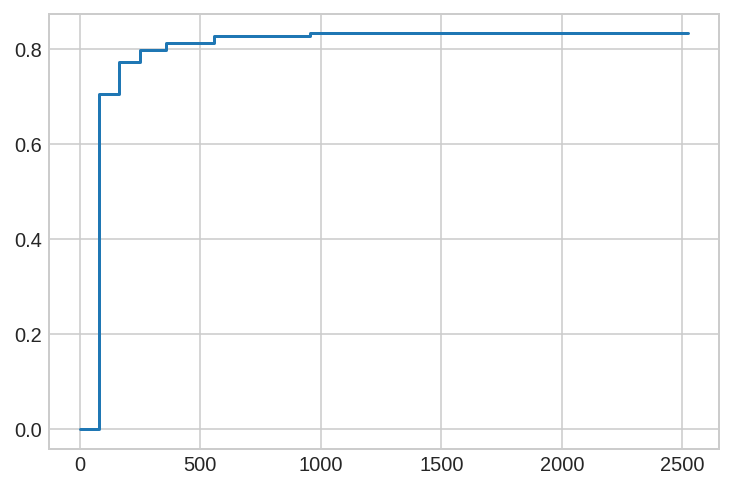

In [23]:
x = [0] + [result.time for result in evolution.results]
x += [x[-1] + (x[-1] - x[-2]) / 10]
y = [0, 0] + [result.best_val_metric for result in evolution.results]
plt.step(x, y)

In [24]:
evolution = Evolution()
hyperparameters = {
    'regularization_penalty': Hyperparameter(3., 2.5, 4.5, 0.5),
    'learning_rate': Hyperparameter(0.0004, 0.0001, 0.0006, 0.000025),
    'batch_size': Hyperparameter(32, 16, 64, 4),
}
evolution.run(x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test),
              layer_sizes=[20, 20, 20, 20, 20], output_neurons=10, hyperparameters=hyperparameters, n_parents=5, population_size=10, 
              n_generations=50, tournament_size=3, n_introduced=2, age_penalty_period=10, use_static_graph=False)

Generation 0: 98.1 s, best val metric 0.7056, [(1, 0.7056, 0.7056, 0.0003386718979544792, 0.0004069589784912005, 33, [20, 20, 20, 20, 20]), (1, 0.7056, 0.7056, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.7056, 0.7056, 0.0003386718979544792, 0.0004069589784912005, 33, [20, 20, 20, 20, 20]), (1, 0.6954, 0.6954, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6853, 0.6853, 0.002155935950363182, 0.0003569042308518582, 28, [20, 20, 20, 20, 20]), (1, 0.6802, 0.6802, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6751, 0.6751, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6751, 0.6751, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6701, 0.6701, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6701, 0.6701, 0.001, 0.0004, 32, [20, 20, 20, 20, 20])]
#### Overall best val metric 0.7055837563451777 ####
Generation 1: 85.4 s, best val metric 0.7716, [(2, 0.7716, 0.7716, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (2, 0.7716, 0.7716, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (2, 0.7716, 0.771

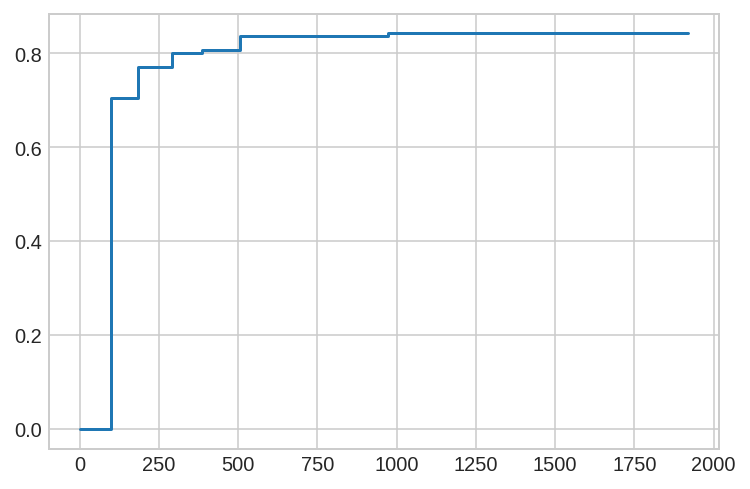

In [25]:
x = [0] + [result.time for result in evolution.results]
x += [x[-1] + (x[-1] - x[-2]) / 10]
y = [0, 0] + [result.best_val_metric for result in evolution.results]
plt.step(x, y)

#### Fine-tuning

In [28]:
evolution = Evolution()
hyperparameters = {
    'regularization_penalty': Hyperparameter(3., 2.5, 4.5, 0.5),
    'learning_rate': Hyperparameter(0.0004, 0.0001, 0.0006, 0.000025),
    'batch_size': Hyperparameter(32, 16, 64, 4),
}
evolution.run(x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test),
              layer_sizes=[20, 20, 20, 20, 20], output_neurons=10, hyperparameters=hyperparameters, n_parents=5, population_size=10, 
              n_generations=50, tournament_size=3, n_introduced=2, age_penalty_period=10, use_static_graph=False, fine_tuning=True)

Generation 0: 65.6 s, best val metric 0.7462, [(1, 0.7462, 0.7462, 0.00042487534303538104, 0.00037724766991369726, 28, [20, 20, 20, 20, 20]), (1, 0.7157, 0.7157, 0.000997615388300815, 0.0004156491630537969, 25, [20, 20, 20, 20, 20]), (1, 0.7157, 0.7157, 0.000997615388300815, 0.0004156491630537969, 25, [20, 20, 20, 20, 20]), (1, 0.6954, 0.6954, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6954, 0.6954, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.665, 0.665, 0.0023069608990303235, 0.0004235222797918026, 34, [20, 20, 20, 20, 20]), (1, 0.665, 0.665, 0.0023069608990303235, 0.0004235222797918026, 34, [20, 20, 20, 20, 20]), (1, 0.6599, 0.6599, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6599, 0.6599, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6497, 0.6497, 0.001, 0.0004, 32, [20, 20, 20, 20, 20])]
#### Overall best val metric 0.7461928934010152 ####
Generation 1: 66.6 s, best val metric 0.7868, [(2, 0.7868, 0.7868, 0.00042487534303538104, 0.00037724766991369726, 28, [20, 20, 2

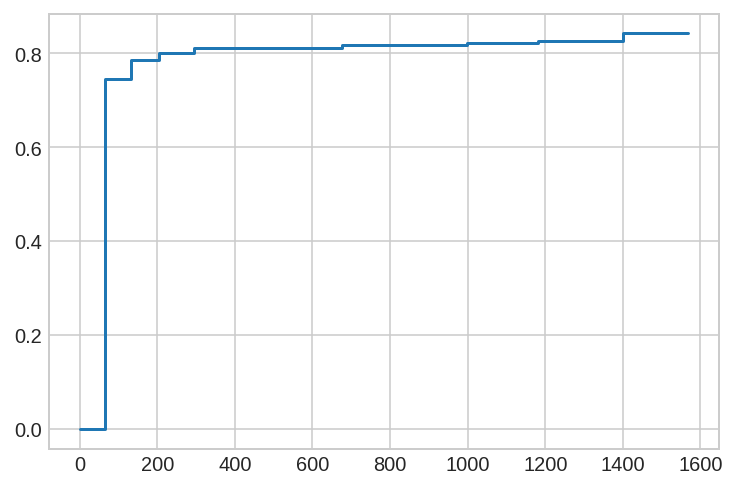

In [29]:
x = [0] + [result.time for result in evolution.results]
x += [x[-1] + (x[-1] - x[-2]) / 10]
y = [0, 0] + [result.best_val_metric for result in evolution.results]
plt.step(x, y)

In [30]:
evolution = Evolution()
hyperparameters = {
    'regularization_penalty': Hyperparameter(3., 2.5, 4.5, 0.5),
    'learning_rate': Hyperparameter(0.0004, 0.0001, 0.0006, 0.000025),
    'batch_size': Hyperparameter(32, 16, 64, 4),
}
evolution.run(x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test),
              layer_sizes=[20, 20, 20, 20, 20], output_neurons=10, hyperparameters=hyperparameters, n_parents=5, population_size=10, 
              n_generations=50, tournament_size=3, n_introduced=2, age_penalty_period=10, use_static_graph=False, fine_tuning=True)

Generation 0: 90.7 s, best val metric 0.7005, [(1, 0.7005, 0.7005, 0.0016639530398982313, 0.00038824380766863036, 37, [20, 20, 20, 20, 20]), (1, 0.7005, 0.7005, 0.0016639530398982313, 0.00038824380766863036, 37, [20, 20, 20, 20, 20]), (1, 0.6802, 0.6802, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6802, 0.6802, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6751, 0.6751, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6751, 0.6751, 0.0006047455983630011, 0.00041815167120119213, 29, [20, 20, 20, 20, 20]), (1, 0.6751, 0.6751, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6701, 0.6701, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6599, 0.6599, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6396, 0.6396, 0.0004848743834409068, 0.0003991010436554287, 28, [20, 20, 20, 20, 20])]
#### Overall best val metric 0.700507614213198 ####
Generation 1: 110.9 s, best val metric 0.802, [(2, 0.802, 0.802, 0.00040782169110330674, 0.000365915418284352, 30, [20, 20, 20, 20, 20]), (2, 0.7766, 0.77

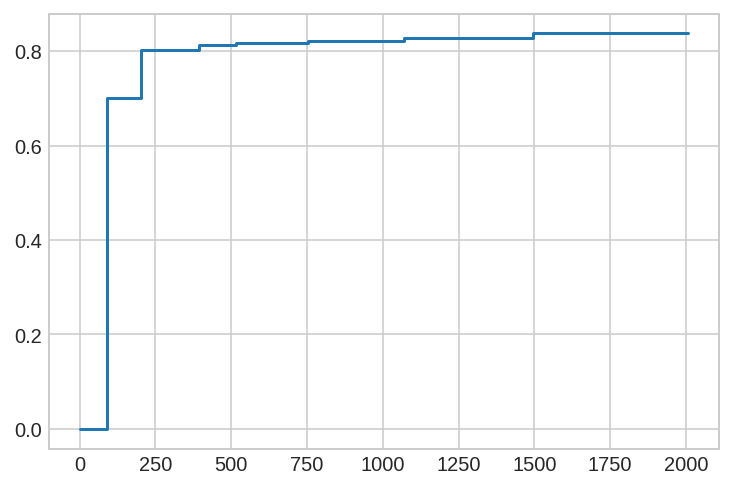

In [31]:
x = [0] + [result.time for result in evolution.results]
x += [x[-1] + (x[-1] - x[-2]) / 10]
y = [0, 0] + [result.best_val_metric for result in evolution.results]
plt.step(x, y)

In [32]:
evolution = Evolution()
hyperparameters = {
    'regularization_penalty': Hyperparameter(3., 2.5, 4.5, 0.5),
    'learning_rate': Hyperparameter(0.0004, 0.0001, 0.0006, 0.000025),
    'batch_size': Hyperparameter(32, 16, 64, 4),
}
evolution.run(x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test),
              layer_sizes=[20, 20, 20, 20, 20], output_neurons=10, hyperparameters=hyperparameters, n_parents=5, population_size=10, 
              n_generations=50, tournament_size=3, n_introduced=2, age_penalty_period=10, use_static_graph=False, fine_tuning=True)

Generation 0: 68.4 s, best val metric 0.7259, [(1, 0.7259, 0.7259, 4.5260504121845285e-05, 0.00041156713469941124, 23, [20, 39, 40, 40, 40]), (1, 0.7259, 0.7259, 4.5260504121845285e-05, 0.00041156713469941124, 23, [20, 39, 40, 40, 40]), (1, 0.7259, 0.7259, 4.5260504121845285e-05, 0.00041156713469941124, 23, [20, 39, 40, 40, 40]), (1, 0.7259, 0.7259, 4.5260504121845285e-05, 0.00041156713469941124, 23, [20, 39, 40, 40, 40]), (1, 0.7107, 0.7107, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6954, 0.6954, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6904, 0.6904, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6904, 0.6904, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6853, 0.6853, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6701, 0.6701, 0.0029484168277212463, 0.0003986067362190583, 36, [20, 20, 20, 20, 20])]
#### Overall best val metric 0.7258883248730964 ####
Generation 1: 76.5 s, best val metric 0.7868, [(2, 0.7868, 0.7868, 4.5260504121845285e-05, 0.00041156713469941124, 23

# Legacy code

## Random search

### Ratio 0.005

In [72]:
%%time

histories, best_overall_combination = random_search(
    train_fn_conv, x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test), 
    learning_rate=0.0004, schedule=PowerRange(-4, -2.5, lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')] * 20)), layer_sizes=[20, 20, 20, 20, 20], 
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2
)

Transformed value 0.00041534645368884667 to 6ac1742dea.
Run with parameters (0.0004, 6ac1742dea, [20, 20, 20, 20, 20], 10, 20, 0.2) started...
Run with parameters (0.0004, 6ac1742dea, [20, 20, 20, 20, 20], 10, 20, 0.2) completed, best_val_loss: 1.0397995710372925, best_val_metric: 0.6842105263157895, best_hidden_layer_sizes: [20, 20, 20, 20, 20]
Transformed value 0.0013678179300379248 to cdc55f9239.
Run with parameters (0.0004, cdc55f9239, [20, 20, 20, 20, 20], 10, 20, 0.2) started...
Run with parameters (0.0004, cdc55f9239, [20, 20, 20, 20, 20], 10, 20, 0.2) completed, best_val_loss: 0.8996500968933105, best_val_metric: 0.7105263157894737, best_hidden_layer_sizes: [20, 20, 20, 20, 20]
Transformed value 0.000487782514601775 to 2eddbf0c7c.
Run with parameters (0.0004, 2eddbf0c7c, [20, 20, 20, 20, 20], 10, 20, 0.2) started...
Run with parameters (0.0004, 2eddbf0c7c, [20, 20, 20, 20, 20], 10, 20, 0.2) completed, best_val_loss: 0.8693010210990906, best_val_metric: 0.631578947368421, best_h

TypeError: cannot unpack non-iterable NoneType object

In [74]:
%%time

histories, best_overall_combination = random_search(
    train_fn_conv, x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test), 
    learning_rate=0.0004, schedule=PowerRange(-4, -2.5, lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')] * 20)), layer_sizes=[20, 20, 20, 20, 20], 
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2
)

Transformed value 0.001439351576826643 to 30be2b3482.
Run with parameters (0.0004, 30be2b3482, [20, 20, 20, 20, 20], 10, 20, 0.2) started...
Run with parameters (0.0004, 30be2b3482, [20, 20, 20, 20, 20], 10, 20, 0.2) completed, best_val_loss: 0.95672208070755, best_val_metric: 0.6842105263157895, best_hidden_layer_sizes: [20, 20, 20, 20, 20]
Transformed value 0.00025685508461890423 to bdcb7b6396.
Run with parameters (0.0004, bdcb7b6396, [20, 20, 20, 20, 20], 10, 20, 0.2) started...
Run with parameters (0.0004, bdcb7b6396, [20, 20, 20, 20, 20], 10, 20, 0.2) completed, best_val_loss: 0.7996328473091125, best_val_metric: 0.6578947368421053, best_hidden_layer_sizes: [20, 20, 20, 20, 20]
Transformed value 0.0031164959282910234 to cd16e3065c.
Run with parameters (0.0004, cd16e3065c, [20, 20, 20, 20, 20], 10, 20, 0.2) started...
Run with parameters (0.0004, cd16e3065c, [20, 20, 20, 20, 20], 10, 20, 0.2) completed, best_val_loss: 1.1780805587768555, best_val_metric: 0.5789473684210527, best_hi

TypeError: cannot unpack non-iterable NoneType object

In [97]:
random_search = RandomSearch()
random_search.run(
    train_fn_conv, x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test), 
    learning_rate=0.0004, schedule=PowerRange(-4, -2.5, lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')] * 20)), layer_sizes=[20, 20, 20, 20, 20], 
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2
)

Transformed value 0.00042521825721349133 to fdf215cf84.
Run with parameters (0.0004, fdf215cf84, [20, 20, 20, 20, 20], 10, 20, 0.2) started...
Run with parameters (0.0004, fdf215cf84, [20, 20, 20, 20, 20], 10, 20, 0.2) completed, best_val_loss: 0.9520576596260071, best_val_metric: 0.6842105263157895, best_hidden_layer_sizes: [20, 20, 20, 20, 20]
Transformed value 0.0008922229271696954 to 1789056010.
Run with parameters (0.0004, 1789056010, [20, 20, 20, 20, 20], 10, 20, 0.2) started...
Run with parameters (0.0004, 1789056010, [20, 20, 20, 20, 20], 10, 20, 0.2) completed, best_val_loss: 0.9162994027137756, best_val_metric: 0.7631578947368421, best_hidden_layer_sizes: [20, 20, 20, 20, 20]
Transformed value 0.0010076891993239365 to fedfb3f038.
Run with parameters (0.0004, fedfb3f038, [20, 20, 20, 20, 20], 10, 20, 0.2) started...
Run with parameters (0.0004, fedfb3f038, [20, 20, 20, 20, 20], 10, 20, 0.2) completed, best_val_loss: 1.0485434532165527, best_val_metric: 0.7105263157894737, best

In [98]:
random_search.results

[(21.270880222320557, 0.6842105263157895),
 (42.808112382888794, 0.7631578947368421),
 (64.3229489326477, 0.7631578947368421),
 (85.85527348518372, 0.7631578947368421),
 (107.26386427879333, 0.7631578947368421),
 (128.31746411323547, 0.7631578947368421),
 (150.12859892845154, 0.7631578947368421),
 (171.3938684463501, 0.7631578947368421),
 (192.60103964805603, 0.7631578947368421)]

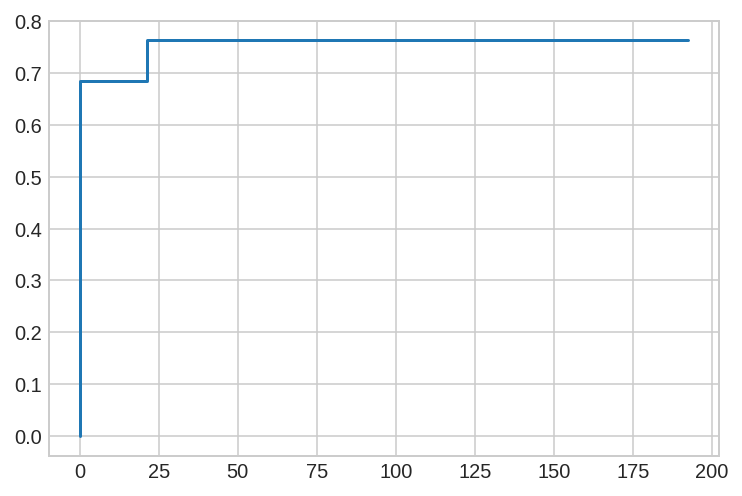

In [100]:
x = [0] + [x[0] for x in random_search.results]
y = [0] + [x[1] for x in random_search.results]
plt.step(x, y)

### Ratio 0.02

In [39]:
random_search = RandomSearch()
random_search.run(
    train_fn_conv, x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test), 
    learning_rate=0.0004, schedule=PowerRange(-4, -2.5, lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')] * 20)), layer_sizes=[20, 20, 20, 20, 20], 
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2
)

Transformed value 0.001962922452895973 to dc5ad78bf4.
Run with parameters (0.0004, dc5ad78bf4, [20, 20, 20, 20, 20], 10, 20, 0.2) started...
Run with parameters (0.0004, dc5ad78bf4, [20, 20, 20, 20, 20], 10, 20, 0.2) completed, best_val_loss: 0.7617141604423523, best_val_metric: 0.7817258883248731, best_hidden_layer_sizes: [20, 20, 20, 20, 20]
Transformed value 0.0017044215519336813 to 7fc4cb9d4b.
Run with parameters (0.0004, 7fc4cb9d4b, [20, 20, 20, 20, 20], 10, 20, 0.2) started...
Run with parameters (0.0004, 7fc4cb9d4b, [20, 20, 20, 20, 20], 10, 20, 0.2) completed, best_val_loss: 0.7128424644470215, best_val_metric: 0.7918781725888325, best_hidden_layer_sizes: [20, 20, 20, 20, 20]
Transformed value 0.00030719592667436573 to c55841f332.
Run with parameters (0.0004, c55841f332, [20, 20, 20, 20, 20], 10, 20, 0.2) started...
Run with parameters (0.0004, c55841f332, [20, 20, 20, 20, 20], 10, 20, 0.2) completed, best_val_loss: 0.6158793568611145, best_val_metric: 0.8071065989847716, best_

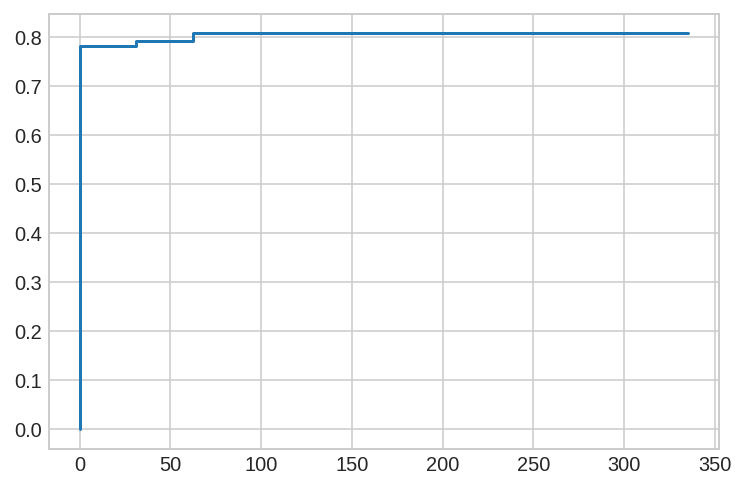

In [41]:
x = [0] + [x[0] for x in random_search.val_metrics]
y = [0] + [x[1] for x in random_search.val_metrics]
plt.step(x, y)

In [25]:
random_search = RandomSearch()
random_search.run(
    train_fn_conv, x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test), 
    learning_rate=0.0004, schedule=Schedule([StaticEpochNoRegularization()] * 20), 
    layer_sizes=UniformRange(10, 60, lambda x: [x] * 5, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2
)

Transformed value 56 to [56, 56, 56, 56, 56].
Run with parameters (0.0004, e10c3a90f5, [56, 56, 56, 56, 56], 10, 20, 0.2) started...
Run with parameters (0.0004, e10c3a90f5, [56, 56, 56, 56, 56], 10, 20, 0.2) completed, best_val_loss: 0.7135776281356812, best_val_metric: 0.8020304568527918, best_hidden_layer_sizes: [56, 56, 56, 56, 56]
Transformed value 17 to [17, 17, 17, 17, 17].
Run with parameters (0.0004, e10c3a90f5, [17, 17, 17, 17, 17], 10, 20, 0.2) started...
Run with parameters (0.0004, e10c3a90f5, [17, 17, 17, 17, 17], 10, 20, 0.2) completed, best_val_loss: 0.5698947310447693, best_val_metric: 0.817258883248731, best_hidden_layer_sizes: [17, 17, 17, 17, 17]
Transformed value 26 to [26, 26, 26, 26, 26].
Run with parameters (0.0004, e10c3a90f5, [26, 26, 26, 26, 26], 10, 20, 0.2) started...
Run with parameters (0.0004, e10c3a90f5, [26, 26, 26, 26, 26], 10, 20, 0.2) completed, best_val_loss: 0.6505106687545776, best_val_metric: 0.8121827411167513, best_hidden_layer_sizes: [26, 26,

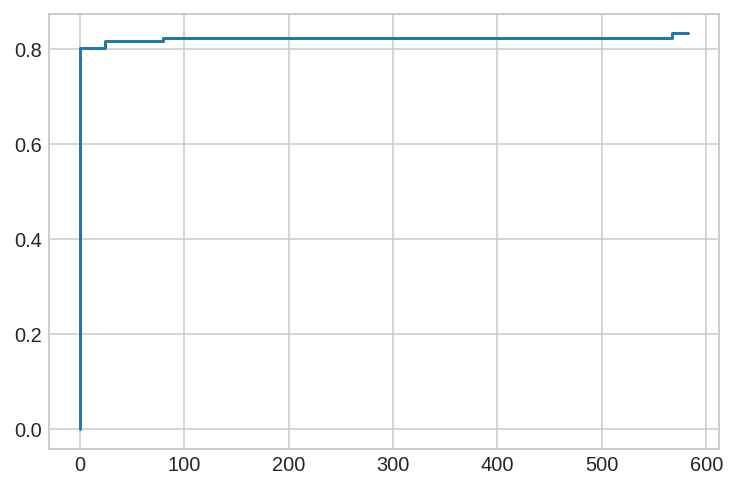

In [26]:
x = [0] + [x[0] for x in random_search.val_metrics]
y = [0] + [x[1] for x in random_search.val_metrics]
plt.step(x, y)

In [35]:
random_search = RandomSearch()
random_search.run(
    train_fn_conv, x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test), 
    learning_rate=0.0004, schedule=PowerRange(-4, -1, lambda x: Schedule([StaticEpoch(x, 'l1')] * 20)), 
    layer_sizes=UniformRange(10, 60, lambda x: [x] * 5, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2
)

Transformed value 0.0015647224510419461 to 70ad510894.
Transformed value 50 to [50, 50, 50, 50, 50].
Run with parameters (0.0004, 70ad510894, [50, 50, 50, 50, 50], 10, 20, 0.2) started...
Run with parameters (0.0004, 70ad510894, [50, 50, 50, 50, 50], 10, 20, 0.2) completed, best_val_loss: 0.63899827003479, best_val_metric: 0.8121827411167513, best_hidden_layer_sizes: [50, 50, 50, 50, 50]
Transformed value 0.0055191252041712924 to 054379149d.
Transformed value 41 to [41, 41, 41, 41, 41].
Run with parameters (0.0004, 054379149d, [41, 41, 41, 41, 41], 10, 20, 0.2) started...
Run with parameters (0.0004, 054379149d, [41, 41, 41, 41, 41], 10, 20, 0.2) completed, best_val_loss: 0.569776177406311, best_val_metric: 0.817258883248731, best_hidden_layer_sizes: [41, 41, 41, 41, 41]
Transformed value 0.004552519234309237 to 0f0ab74ebe.
Transformed value 26 to [26, 26, 26, 26, 26].
Run with parameters (0.0004, 0f0ab74ebe, [26, 26, 26, 26, 26], 10, 20, 0.2) started...
Run with parameters (0.0004, 0f

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f0d30d291f0>
Traceback (most recent call last):
  File "/home/vojta/.miniconda3/envs/self-scaling-nets/lib/python3.8/weakref.py", line 345, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


Interrupted by user.


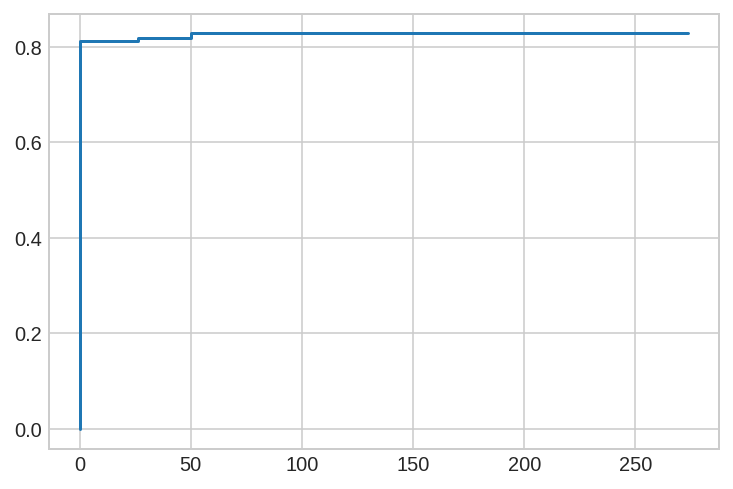

In [36]:
x = [0] + [x[0] for x in random_search.val_metrics]
y = [0] + [x[1] for x in random_search.val_metrics]
plt.step(x, y)

#### Promising results

In [164]:
random_search = RandomSearch()
random_search.run(
    train_fn_conv, x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test), 
    learning_rate=0.0004, schedule=PowerRange(-4, -2.5, lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')] * 20)), layer_sizes=[20, 20, 20, 20, 20], 
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2
)

Transformed value 0.0002690672152324276 to 0ca5a9c378.
Run with parameters (0.0004, 0ca5a9c378, [20, 20, 20, 20, 20], 10, 20, 0.2) started...
Run with parameters (0.0004, 0ca5a9c378, [20, 20, 20, 20, 20], 10, 20, 0.2) completed, best_val_loss: 0.6647390723228455, best_val_metric: 0.8020304568527918, best_hidden_layer_sizes: [20, 20, 20, 20, 20]
Best overall combination: (0.0004, 0ca5a9c378, [20, 20, 20, 20, 20], 10, 20, 0.2), val_metric: 0.8020304568527918
Transformed value 0.0006377418780501754 to 4dd7336522.
Run with parameters (0.0004, 4dd7336522, [20, 20, 20, 20, 20], 10, 20, 0.2) started...
Run with parameters (0.0004, 4dd7336522, [20, 20, 20, 20, 20], 10, 20, 0.2) completed, best_val_loss: 0.6458284854888916, best_val_metric: 0.8223350253807107, best_hidden_layer_sizes: [20, 20, 20, 20, 20]
Best overall combination: (0.0004, 4dd7336522, [20, 20, 20, 20, 20], 10, 20, 0.2), val_metric: 0.8223350253807107
Transformed value 0.001561167177574867 to 91ab607077.
Run with parameters (0.0

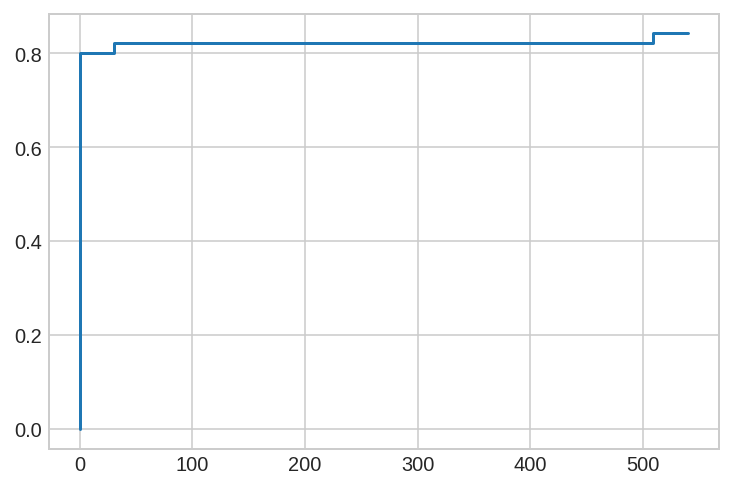

In [165]:
x = [0] + [x[0] for x in random_search.val_metrics]
y = [0] + [x[1] for x in random_search.val_metrics]
plt.step(x, y)

In [157]:
random_search = RandomSearch()
random_search.run(
    train_fn_conv, x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test), 
    learning_rate=0.0004, schedule=PowerRange(-4.5, -2.5, lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')] * 13 + [StaticEpochNoRegularization()] * 7)), 
    layer_sizes=[20, 20, 20, 20, 20], output_neurons=10, min_new_neurons=20, growth_percentage=0.2
)

Run with parameters (0.0004, e79c390bde(0.0015803551481830696), [20, 20, 20, 20, 20], 10, 20, 0.2) started...
Run with parameters (0.0004, e79c390bde(0.0015803551481830696), [20, 20, 20, 20, 20], 10, 20, 0.2) completed, best_val_loss: 0.5826945304870605, best_val_metric: 0.8121827411167513, best_hidden_layer_sizes: [20, 20, 20, 20, 20]
Best overall combination: (0.0004, e79c390bde(0.0015803551481830696), [20, 20, 20, 20, 20], 10, 20, 0.2), val_metric: 0.8121827411167513
Run with parameters (0.0004, 3684e73514(0.001990742744873632), [20, 20, 20, 20, 20], 10, 20, 0.2) started...
Run with parameters (0.0004, 3684e73514(0.001990742744873632), [20, 20, 20, 20, 20], 10, 20, 0.2) completed, best_val_loss: 0.5542274117469788, best_val_metric: 0.817258883248731, best_hidden_layer_sizes: [20, 20, 20, 20, 20]
Best overall combination: (0.0004, 3684e73514(0.001990742744873632), [20, 20, 20, 20, 20], 10, 20, 0.2), val_metric: 0.817258883248731
Run with parameters (0.0004, 537cada78c(0.0004963390684

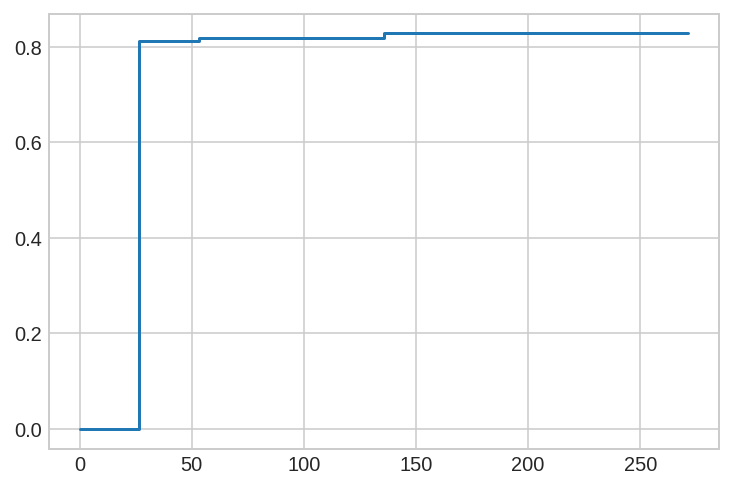

In [158]:
x = [0] + [x[0] for x in random_search.val_metrics]
x += [x[-1] + (x[-1] - x[-2]) / 10]
y = [0, 0] + [x[1] for x in random_search.val_metrics]
plt.step(x, y)

In [166]:
random_search = RandomSearch()
random_search.run(
    train_fn_conv, x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test), 
    learning_rate=0.0004, schedule=PowerRange(-4, -1, lambda x: Schedule([StaticEpoch(x, 'l1')] * 20)), 
    layer_sizes=UniformRange(10, 100, lambda x: [x] * 5, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2
)

Transformed value 0.02518520624046292 to 11241b38f7.
Transformed value 42 to [42, 42, 42, 42, 42].
Run with parameters (0.0004, 11241b38f7, [42, 42, 42, 42, 42], 10, 20, 0.2) started...
Run with parameters (0.0004, 11241b38f7, [42, 42, 42, 42, 42], 10, 20, 0.2) completed, best_val_loss: 0.917365550994873, best_val_metric: 0.7766497461928934, best_hidden_layer_sizes: [42, 42, 42, 42, 42]
Best overall combination: (0.0004, 11241b38f7, [42, 42, 42, 42, 42], 10, 20, 0.2), val_metric: 0.7766497461928934
Transformed value 0.0005932439705257152 to e54cffd593.
Transformed value 35 to [35, 35, 35, 35, 35].
Run with parameters (0.0004, e54cffd593, [35, 35, 35, 35, 35], 10, 20, 0.2) started...
Run with parameters (0.0004, e54cffd593, [35, 35, 35, 35, 35], 10, 20, 0.2) completed, best_val_loss: 0.6492508053779602, best_val_metric: 0.7918781725888325, best_hidden_layer_sizes: [35, 35, 35, 35, 35]
Best overall combination: (0.0004, e54cffd593, [35, 35, 35, 35, 35], 10, 20, 0.2), val_metric: 0.791878

In [179]:
random_search = RandomSearch()
random_search.run(
    train_fn_conv, x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test), 
    learning_rate=0.0004, schedule=PowerRange(-4, -2.5, lambda x: Schedule([StaticEpoch(x, 'l1')] * 20)), 
    layer_sizes=UniformRange(10, 100, lambda x: [x] * 5, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False
)

Transformed value 0.0009662030509360944 to b65eaa8e93.
Transformed value 15 to [15, 15, 15, 15, 15].
Run with parameters (0.0004, b65eaa8e93, [15, 15, 15, 15, 15], 10, 20, 0.2, False) started...
Run with parameters (0.0004, b65eaa8e93, [15, 15, 15, 15, 15], 10, 20, 0.2, False) completed, best_val_loss: 0.6498957872390747, best_val_metric: 0.7817258883248731, best_hidden_layer_sizes: [15, 15, 15, 15, 15]
Best overall combination: (0.0004, b65eaa8e93, [15, 15, 15, 15, 15], 10, 20, 0.2, False), val_metric: 0.7817258883248731
Transformed value 0.0003267030556988157 to 273236d7f9.
Transformed value 18 to [18, 18, 18, 18, 18].
Run with parameters (0.0004, 273236d7f9, [18, 18, 18, 18, 18], 10, 20, 0.2, False) started...
Run with parameters (0.0004, 273236d7f9, [18, 18, 18, 18, 18], 10, 20, 0.2, False) completed, best_val_loss: 0.6477029919624329, best_val_metric: 0.7918781725888325, best_hidden_layer_sizes: [18, 18, 18, 18, 18]
Best overall combination: (0.0004, 273236d7f9, [18, 18, 18, 18, 1

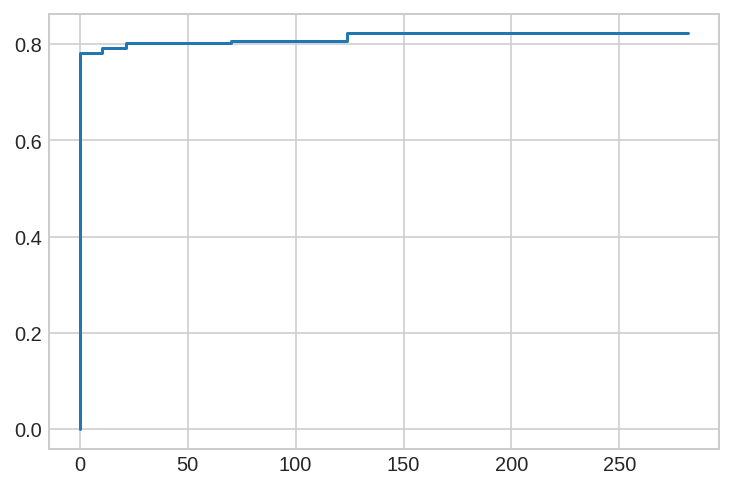

In [180]:
x = [0] + [x[0] for x in random_search.val_metrics]
y = [0] + [x[1] for x in random_search.val_metrics]
plt.step(x, y)

## Anytime Grid Search

In [131]:
grid_search = AnytimeGridSearch()
grid_search.run(
    train_fn_conv, x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test), 
    learning_rate=0.0004, schedule=PowerRange(-4, -2.5, lambda x: Schedule([StaticEpoch(x, 'l1')] * 20)), 
    layer_sizes=UniformRange(10, 100, lambda x: [x] * 5, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False
)

Run with parameters [0.0004, e1abfab0e8(0.0005623413251903491), [55, 55, 55, 55, 55], 10, 20, 0.2, False] started...
Run with parameters [0.0004, e1abfab0e8(0.0005623413251903491), [55, 55, 55, 55, 55], 10, 20, 0.2, False] completed, best_val_loss: 0.6302269697189331, best_val_metric: 0.8121827411167513, best_hidden_layer_sizes: [55, 55, 55, 55, 55]
Best overall combination: [0.0004, e1abfab0e8(0.0005623413251903491), [55, 55, 55, 55, 55], 10, 20, 0.2, False], val_metric: 0.8121827411167513
Run with parameters [0.0004, 3543b1996a(0.001333521432163324), [32, 32, 32, 32, 32], 10, 20, 0.2, False] started...
Run with parameters [0.0004, 3543b1996a(0.001333521432163324), [32, 32, 32, 32, 32], 10, 20, 0.2, False] completed, best_val_loss: 0.6008655428886414, best_val_metric: 0.8121827411167513, best_hidden_layer_sizes: [32, 32, 32, 32, 32]
Best overall combination: [0.0004, e1abfab0e8(0.0005623413251903491), [55, 55, 55, 55, 55], 10, 20, 0.2, False], val_metric: 0.8121827411167513
Run with p

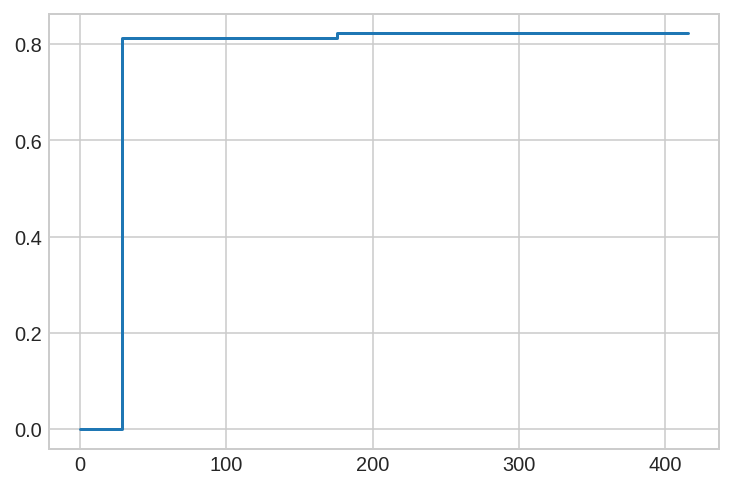

In [154]:
x = [0] + [x[0] for x in grid_search.val_metrics]
x += [x[-1] + (x[-1] - x[-2]) / 10]
y = [0, 0] + [x[1] for x in grid_search.val_metrics]
plt.step(x, y)

In [168]:
grid_search = AnytimeGridSearch()
grid_search.run(
    train_fn_conv, x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test), 
    learning_rate=0.0004, schedule=Schedule([StaticEpochNoRegularization()] * 20), 
    layer_sizes=UniformRange(10, 100, lambda x: [x] * 5, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False
)

Run with parameters [0.0004, e10c3a90f5(0.0), [55, 55, 55, 55, 55], 10, 20, 0.2, False] started...
Run with parameters [0.0004, e10c3a90f5(0.0), [55, 55, 55, 55, 55], 10, 20, 0.2, False] completed, best_val_loss: 0.6817042231559753, best_val_metric: 0.8020304568527918, best_hidden_layer_sizes: [55, 55, 55, 55, 55]
Best overall combination: [0.0004, e10c3a90f5(0.0), [55, 55, 55, 55, 55], 10, 20, 0.2, False], val_metric: 0.8020304568527918
Run with parameters [0.0004, e10c3a90f5(0.0), [32, 32, 32, 32, 32], 10, 20, 0.2, False] started...
Run with parameters [0.0004, e10c3a90f5(0.0), [32, 32, 32, 32, 32], 10, 20, 0.2, False] completed, best_val_loss: 0.5723802447319031, best_val_metric: 0.8121827411167513, best_hidden_layer_sizes: [32, 32, 32, 32, 32]
Best overall combination: [0.0004, e10c3a90f5(0.0), [32, 32, 32, 32, 32], 10, 20, 0.2, False], val_metric: 0.8121827411167513
Run with parameters [0.0004, e10c3a90f5(0.0), [78, 78, 78, 78, 78], 10, 20, 0.2, False] started...
Run with paramete

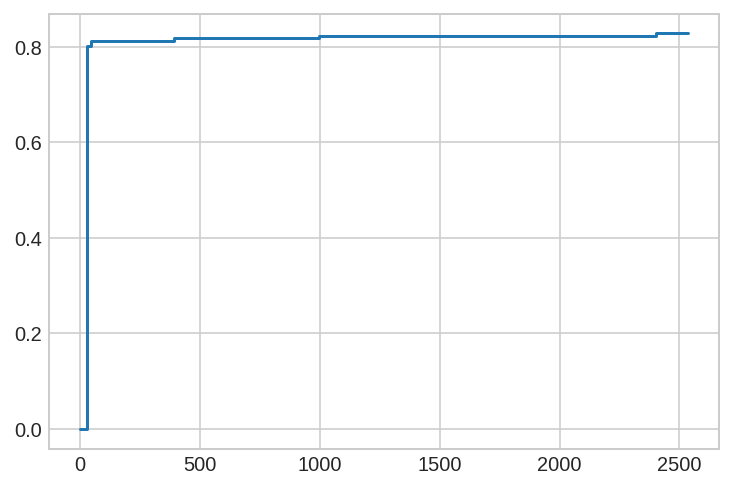

In [169]:
x = [0] + [x[0] for x in grid_search.val_metrics]
x += [x[-1] + (x[-1] - x[-2]) / 10]
y = [0, 0] + [x[1] for x in grid_search.val_metrics]
plt.step(x, y)

In [160]:
grid_search = AnytimeGridSearch()
grid_search.run(
    train_fn_conv, x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test), 
    learning_rate=0.0004, schedule=PowerRange(-4, -2.5, lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')] * 20)), layer_sizes=[20, 20, 20, 20, 20], 
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False
)

Run with parameters [0.0004, 602574c98b(0.0005623413251903491), [20, 20, 20, 20, 20], 10, 20, 0.2, False] started...
Run with parameters [0.0004, 602574c98b(0.0005623413251903491), [20, 20, 20, 20, 20], 10, 20, 0.2, False] completed, best_val_loss: 0.6294623017311096, best_val_metric: 0.8071065989847716, best_hidden_layer_sizes: [20, 20, 20, 20, 20]
Best overall combination: [0.0004, 602574c98b(0.0005623413251903491), [20, 20, 20, 20, 20], 10, 20, 0.2, False], val_metric: 0.8071065989847716
Run with parameters [0.0004, 037749c3fa(0.00023713737056616554), [20, 20, 20, 20, 20], 10, 20, 0.2, False] started...
Run with parameters [0.0004, 037749c3fa(0.00023713737056616554), [20, 20, 20, 20, 20], 10, 20, 0.2, False] completed, best_val_loss: 0.5229137539863586, best_val_metric: 0.8324873096446701, best_hidden_layer_sizes: [20, 20, 20, 20, 20]
Best overall combination: [0.0004, 037749c3fa(0.00023713737056616554), [20, 20, 20, 20, 20], 10, 20, 0.2, False], val_metric: 0.8324873096446701
Run w

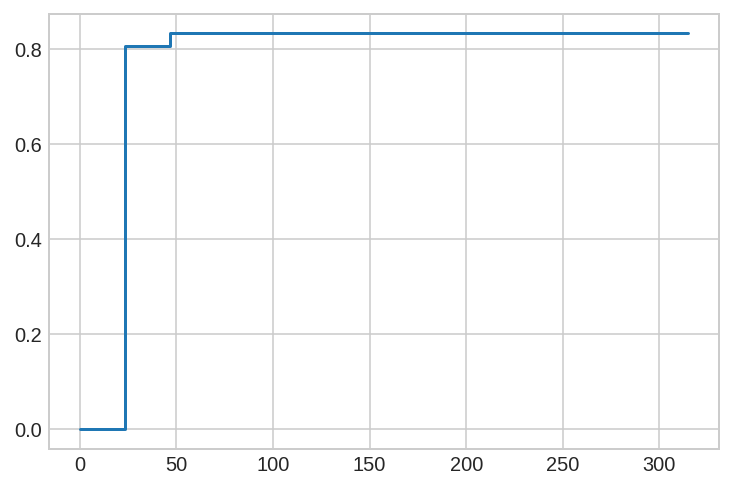

In [161]:
x = [0] + [x[0] for x in grid_search.val_metrics]
x += [x[-1] + (x[-1] - x[-2]) / 10]
y = [0, 0] + [x[1] for x in grid_search.val_metrics]
plt.step(x, y)

In [163]:
grid_search = AnytimeGridSearch()
grid_search.run(
    train_fn_conv, x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test), 
    learning_rate=0.0004, schedule=PowerRange(-4, -2.5, lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')] * 13 + [StaticEpochNoRegularization()] * 7)), 
    layer_sizes=[20, 20, 20, 20, 20], output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False
)

Run with parameters [0.0004, cf6aec34fc(0.0005623413251903491), [20, 20, 20, 20, 20], 10, 20, 0.2, False] started...
Run with parameters [0.0004, cf6aec34fc(0.0005623413251903491), [20, 20, 20, 20, 20], 10, 20, 0.2, False] completed, best_val_loss: 0.5712668299674988, best_val_metric: 0.8223350253807107, best_hidden_layer_sizes: [20, 20, 20, 20, 20]
Best overall combination: [0.0004, cf6aec34fc(0.0005623413251903491), [20, 20, 20, 20, 20], 10, 20, 0.2, False], val_metric: 0.8223350253807107
Run with parameters [0.0004, e3001bad73(0.001333521432163324), [20, 20, 20, 20, 20], 10, 20, 0.2, False] started...
Run with parameters [0.0004, e3001bad73(0.001333521432163324), [20, 20, 20, 20, 20], 10, 20, 0.2, False] completed, best_val_loss: 0.5780638456344604, best_val_metric: 0.8223350253807107, best_hidden_layer_sizes: [20, 20, 20, 20, 20]
Best overall combination: [0.0004, cf6aec34fc(0.0005623413251903491), [20, 20, 20, 20, 20], 10, 20, 0.2, False], val_metric: 0.8223350253807107
Run with p

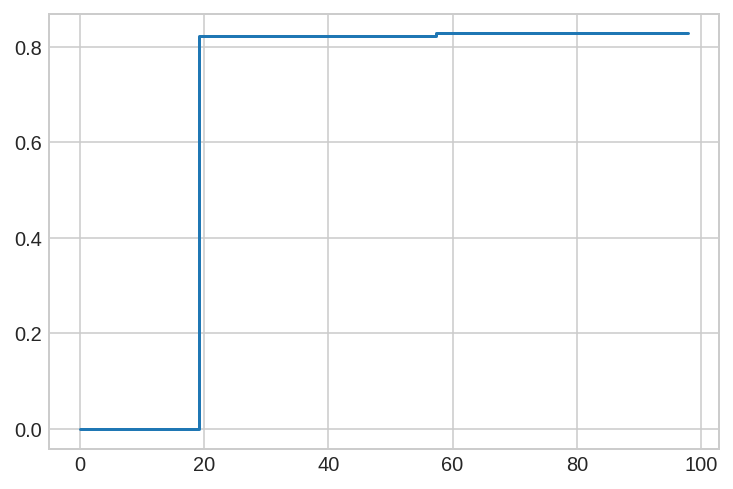

In [164]:
x = [0] + [x[0] for x in grid_search.val_metrics]
x += [x[-1] + (x[-1] - x[-2]) / 10]
y = [0, 0] + [x[1] for x in grid_search.val_metrics]
plt.step(x, y)

In [167]:
grid_search = AnytimeGridSearch()
grid_search.run(
    train_fn_conv, x=fashion_mnist.X_train_norm, y=fashion_mnist.y_train, validation_data=(fashion_mnist.X_test_norm, fashion_mnist.y_test), 
    learning_rate=0.0004, schedule=PowerRange(-4.5, -4, lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')] * 20)), 
    layer_sizes=[20, 20, 20, 20, 20], output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False
)

Run with parameters [0.0004, 955422b558(5.623413251903491e-05), [20, 20, 20, 20, 20], 10, 20, 0.2, False] started...
Run with parameters [0.0004, 955422b558(5.623413251903491e-05), [20, 20, 20, 20, 20], 10, 20, 0.2, False] completed, best_val_loss: 0.6611381769180298, best_val_metric: 0.7969543147208121, best_hidden_layer_sizes: [20, 24, 20, 41, 20]
Best overall combination: [0.0004, 955422b558(5.623413251903491e-05), [20, 20, 20, 20, 20], 10, 20, 0.2, False], val_metric: 0.7969543147208121
Run with parameters [0.0004, dddd93f061(4.216965034285822e-05), [20, 20, 20, 20, 20], 10, 20, 0.2, False] started...
Run with parameters [0.0004, dddd93f061(4.216965034285822e-05), [20, 20, 20, 20, 20], 10, 20, 0.2, False] completed, best_val_loss: 0.6429683566093445, best_val_metric: 0.8020304568527918, best_hidden_layer_sizes: [25, 39, 23, 73, 22]
Best overall combination: [0.0004, dddd93f061(4.216965034285822e-05), [20, 20, 20, 20, 20], 10, 20, 0.2, False], val_metric: 0.8020304568527918
Run with

## Cifar 10

### Ratio 0.02

In [172]:
cifar10 = get_cifar_10_dataset(fraction=0.02)

In [173]:
random_search = RandomSearch()
random_search.run(
    train_fn_conv, x=cifar10.X_train_norm, y=cifar10.y_train, validation_data=(cifar10.X_test_norm, cifar10.y_test), 
    learning_rate=0.0004, schedule=PowerRange(-5, -2.5, lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')] * 20)), layer_sizes=[20, 20, 20, 20, 20], 
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False
)

Transformed value 0.0008065605947991057 to 806a72f301.
Run with parameters (0.0004, 806a72f301, [20, 20, 20, 20, 20], 10, 20, 0.2, False) started...
Run with parameters (0.0004, 806a72f301, [20, 20, 20, 20, 20], 10, 20, 0.2, False) completed, best_val_loss: 1.8997548818588257, best_val_metric: 0.37055837563451777, best_hidden_layer_sizes: [20, 20, 20, 20, 20]
Best overall combination: (0.0004, 806a72f301, [20, 20, 20, 20, 20], 10, 20, 0.2, False), val_metric: 0.37055837563451777
Transformed value 4.787375323359042e-05 to 9f3dfa33a4.
Run with parameters (0.0004, 9f3dfa33a4, [20, 20, 20, 20, 20], 10, 20, 0.2, False) started...
Run with parameters (0.0004, 9f3dfa33a4, [20, 20, 20, 20, 20], 10, 20, 0.2, False) completed, best_val_loss: 1.9053282737731934, best_val_metric: 0.37055837563451777, best_hidden_layer_sizes: [23, 21, 20, 41, 20]
Best overall combination: (0.0004, 806a72f301, [20, 20, 20, 20, 20], 10, 20, 0.2, False), val_metric: 0.37055837563451777
Transformed value 9.088304270775

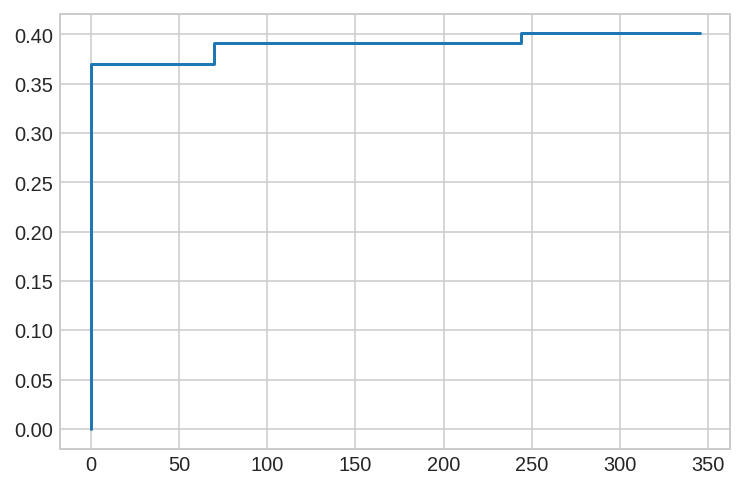

In [174]:
x = [0] + [x[0] for x in random_search.val_metrics]
y = [0] + [x[1] for x in random_search.val_metrics]
plt.step(x, y)

In [181]:
random_search = RandomSearch()
random_search.run(
    train_fn_conv, x=cifar10.X_train_norm, y=cifar10.y_train, validation_data=(cifar10.X_test_norm, cifar10.y_test), 
    learning_rate=0.0004, schedule=PowerRange(-5, -2.5, lambda x: Schedule([StaticEpoch(x, 'l1')] * 20)), 
    layer_sizes=UniformRange(10, 100, lambda x: [x] * 5, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False
)

Transformed value 0.002057566238721228 to c8b5b57561.
Transformed value 94 to [94, 94, 94, 94, 94].
Run with parameters (0.0004, c8b5b57561, [94, 94, 94, 94, 94], 10, 20, 0.2, False) started...
Run with parameters (0.0004, c8b5b57561, [94, 94, 94, 94, 94], 10, 20, 0.2, False) completed, best_val_loss: 2.152656316757202, best_val_metric: 0.38071065989847713, best_hidden_layer_sizes: [94, 94, 94, 94, 94]
Best overall combination: (0.0004, c8b5b57561, [94, 94, 94, 94, 94], 10, 20, 0.2, False), val_metric: 0.38071065989847713
Transformed value 0.0002216839724327367 to 2efac85a7b.
Transformed value 53 to [53, 53, 53, 53, 53].
Run with parameters (0.0004, 2efac85a7b, [53, 53, 53, 53, 53], 10, 20, 0.2, False) started...
Run with parameters (0.0004, 2efac85a7b, [53, 53, 53, 53, 53], 10, 20, 0.2, False) completed, best_val_loss: 1.9773730039596558, best_val_metric: 0.3248730964467005, best_hidden_layer_sizes: [53, 53, 53, 53, 53]
Best overall combination: (0.0004, c8b5b57561, [94, 94, 94, 94, 9

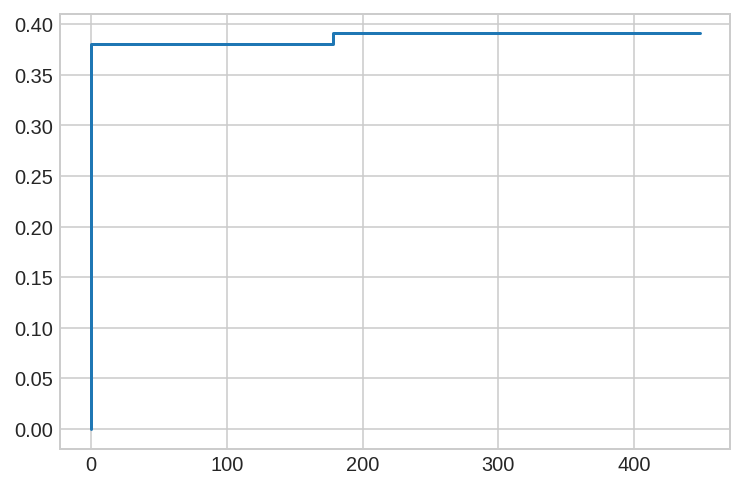

In [182]:
x = [0] + [x[0] for x in random_search.val_metrics]
y = [0] + [x[1] for x in random_search.val_metrics]
plt.step(x, y)

In [183]:
evolution = Evolution()
evolution.run(x=cifar10.X_train_norm, y=cifar10.y_train, validation_data=(cifar10.X_test_norm, cifar10.y_test),
              batch_size=32, layer_sizes=[20, 20, 20, 20, 20], output_neurons=10, learning_rate=0.0004, n_parents=5, strategy=[0.5, 0.05], 
              population_size=10, n_generations=50, tournament_size=3, n_introduced=2, age_penalty_period=10, use_static_graph=False)

Generation 0: 39.4 s, best val metric 0.269, [(1, 0.269, 0.269, 2.7, 0.03, [20, 20, 20, 20, 20]), (1, 0.269, 0.269, 2.7, 0.03, [20, 20, 20, 20, 20]), (1, 0.2487, 0.2487, 3.0, 0.1, [20, 20, 20, 20, 20]), (1, 0.2487, 0.2487, 3.0, 0.1, [20, 20, 20, 20, 20]), (1, 0.2487, 0.2487, 3.0, 0.1, [20, 20, 20, 20, 20]), (1, 0.2437, 0.2437, 3.0, 0.1, [20, 20, 20, 20, 20]), (1, 0.2386, 0.2386, 3.0, 0.1, [20, 20, 20, 20, 20]), (1, 0.2335, 0.2335, 3.0, 0.1, [20, 20, 20, 20, 20]), (1, 0.2183, 0.2183, 3.0, 0.1, [20, 20, 20, 20, 20]), (1, 0.203, 0.203, 3.0, -0.02, [20, 20, 20, 20, 20])]
Generation 1: 41.9 s, best val metric 0.335, [(2, 0.335, 0.335, 3.2, 0.03, [20, 20, 20, 20, 20]), (2, 0.335, 0.335, 3.2, 0.03, [20, 20, 20, 20, 20]), (2, 0.335, 0.335, 3.2, 0.03, [20, 20, 20, 20, 20]), (2, 0.335, 0.335, 3.2, 0.03, [20, 20, 20, 20, 20]), (2, 0.3249, 0.3249, 2.7, 0.03, [20, 20, 20, 20, 20]), (2, 0.3249, 0.3249, 2.7, 0.03, [20, 20, 20, 20, 20]), (2, 0.3249, 0.3249, 2.7, 0.03, [20, 20, 20, 20, 20]), (2, 0.2944

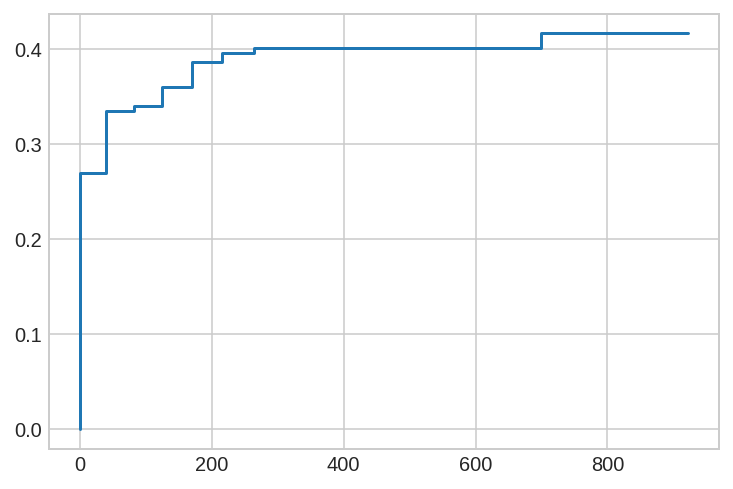

In [185]:
x = [0] + [x[0] for x in evolution.val_metrics]
y = [0] + [x[1] for x in evolution.val_metrics]
plt.step(x, y)